In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import statsmodels as stm
import missingno as msno
import statsmodels.imputation.mice as mice
import random as rn
import os
import missingno as msno
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

rng = np.random.RandomState(10)
  
%matplotlib inline 

In [24]:
#Funzioni costruite
def to_csv(df, path):
    """
    Funzione che permette di salvare il tipo delle variabili contenute in un dataset (che altrimenti verrebbero perse)
    nella prima riga del file csv. Questo permetterà di recupare il tipo anche nelle successive letture.
    INPUT:
    - df: dataframe da salvare
    - path: nome con cui si vuol salvare il file
    """
    df.loc[-1] = df.dtypes
    #Salvo iltipo nella prima riga del file
    df.index = df.index + 1
    df.sort_index(inplace=True)
    # Successivamente salvo il file in formato csv
    df.to_csv(path, index=False)
    
    
def find_file(path,df,flag):
    """
    Funzione che permette di verificare se un file è presente o meno
    INPUT:
    - path: percorso del file con nome finale del file
    - df: dataframe che si vuole salvare
    - flag: segnale che mi permette di salvare e quindi sovrascrivere il file anche se presente
    """
    if not(flag):
        if os.path.isfile(path):
            print("Il file esiste! Se vuoi salvare comunque il file cambia il flag a 1")
        else:
            print("Il file non esiste! Verrà salvato nella cartella File Memory")
            to_csv(df,path)
            
    else:
        to_csv(df,path)
        
#Carico il database contenente la visita 1
def read_csv(path):
    """
    Funzione che permette di recuperare il file selezione e il tipo delle variabili che esso contiene.
    INPUT:
    - path: percorsodel file che si vuole recuperare
    """
    # Leggo il tipo delle variabili dalla prima riga del file
    dtypes = pd.read_csv(path, nrows=1).iloc[0].to_dict()
    # Leggo il resto del file oltre la prima riga
    return pd.read_csv(path, dtype=dtypes, skiprows=[1])

#Creo una funzione per aggiungere missing data
def add_missing_values(X_full, y_full):
    """
    Funzione che dato un dataset cancella i dati in modo casuale, simulando una situazione
    di MCAR (Missing Completely at Random)
    INPUT:
    - X_full: dataset completo
    - y_full: vettore della classe completo
    """
    n_samples, n_features = X_full.shape
    dfMissing = X_full.copy()
    dfMissing -= dfMissing.min()
    dfMissing /= dfMissing.max()
    n_missing = int(0.10*n_samples)  # Decido di andare a cancellare il 5% percento dei dati per ogni colonna 
    for j in X_full.columns:
        if j != "Età" and j !="Sesso" and j !="ID PAZIENTE":
            #Genero un vettore di indici causali di dimensione pari al n_missing
            index_miss = rn.sample(range(1, n_samples), n_missing)
            #Vado a cancellare e sostituire con i NaN i valore in corrispondeza degli indici estratti
            dfMissing.iloc[index_miss, data1.columns.get_loc(j)] = np.nan
    
    X_missing = dfMissing
    y_missing = y_full.values

    return X_missing, y_missing

def get_impute_algorithm(X_missing, X_full, algorithm):
    """
    Funzione che applica l'algoritmo di imputazione ai dati e ne calcola le performance
    INPUT:
    - X_missing: dataset con i dati mancanti
    - X_full: dataset completo
    - algorithm: algoritmo di imputing
    """
    X_imp = algorithm.fit_transform(X_missing)
    score =  mean_squared_error(X_imp, X_full, squared = False)  #Se squared ottendo l'MSE 
    return score


In [3]:
#Lettura del dataset
#Come chiave del dataset vi è il contatore riga poichè non è possibile usare l'ID_PAZ: ci sono più items per lo stesso
dataSet = pd.read_csv("C:/Users/Antonio Montanaro/Desktop/Tesi Magistrale/DatiOriginaliTesi/RedCap_Monzino/CCM341EPIFANIA-UniPvPhenotyping_DATA_LABELS_2021-06-11_1120.csv")

In [4]:
#Creo il nuovo dataSet per le patologie
dataSetPatologie = pd.DataFrame(dataSet["Repeat Instrument"])
dataSetPatologie["ID PAZIENTE"] = pd.DataFrame(dataSet["ID PAZIENTE"])
dataSetPatologie["Repeat Instance"] = pd.DataFrame(dataSet["Repeat Instance"])
dataSetPatologie["Patologia"] = pd.DataFrame(dataSet["Patologia"])
dataSetPatologie["Data della diagnosi "] = pd.DataFrame(dataSet["Data della diagnosi "])
dataSetPatologie["La patologia è attiva?"] = pd.DataFrame(dataSet["La patologia è attiva?"])
dataSetPatologie["Se sì, è in terapia farmacologica?"] = pd.DataFrame(dataSet["Se sì, è in terapia farmacologica?"])
dataSetPatologie.to_csv("dataset_Patologie.csv") #Salvo il dataset delle patologie

#Cancello queste colonne del dataSet principale
del dataSet["Patologia"]
del dataSet["Data della diagnosi "]
del dataSet["La patologia è attiva?"]
del dataSet["Repeat Instrument"]
del dataSet["Se sì, è in terapia farmacologica?"]

#Sfrutto la colonna Repeat Instance prima di cancellarla
# Cancello tutte le righe in cui Repeat Instanze è diverso da Nan poichè la stessa informazione è contenuta 
# nel dataframe 'dataSetPatologie'
dataSet = dataSet.loc[dataSet['Repeat Instance'].isna() == True]
del dataSet['Repeat Instance']

# La colonna 'Codice Epifania' è un codice composta da "EP + X..X + ID_PAZIENTE"
#del dataSet["Codice Epifania"]

#Elimino le colonne che non interessano su argomento "Fumo". Lascio: Info se il paziente fuma e da quanti anni
del dataSet["Per i fumatori e gli ex fumatori indicare se si fuma: (choice=Sigarette)"]
del dataSet["Per i fumatori e gli ex fumatori indicare se si fuma: (choice=Sigarette elettroniche)"]
del dataSet["Per i fumatori e gli ex fumatori indicare se si fuma: (choice=Sigari)"]
del dataSet["Per i fumatori e gli ex fumatori indicare se si fuma: (choice=Pipa)"]
del dataSet["Quanti/e [fumo_tipo] al giorno fuma/fumava?"]
del dataSet["Anno di fine"]

#Modifico le colonne di "Il paziente è un fumatore?" e "Anni da fumatore"
#Il paziente è un fumatore ha tre livelli "MAI", ù"EX", "SI" che verranno codificati rispettivamente in 0,1 e 2  
#Anni da fumatore invece è una continua, controllo se ad EX corrisponde un NAN perchè in quel caso sarebbe zero
for i, row_value in dataSet["Il paziente è un fumatore?"].iteritems():
    if dataSet["Il paziente è un fumatore?"][i] == "MAI":
        dataSet.loc.__setitem__((i, ("Il paziente è un fumatore?")), "0")
        dataSet.loc.__setitem__((i, ("Anni da fumatore")), "0")
    if dataSet["Il paziente è un fumatore?"][i] == "EX":
        dataSet.loc.__setitem__((i, ("Il paziente è un fumatore?")), "1")  
    if dataSet["Il paziente è un fumatore?"][i] == "SI":
        dataSet.loc.__setitem__((i, ("Il paziente è un fumatore?")), "2")
dataSet["Il paziente è un fumatore?"] = dataSet["Il paziente è un fumatore?"].astype("category")

#Modifico la colonna di "Il paziente fa attività fisica?" 
# E' una variabile categorica con 4 livelli "Nulla", "Bassa", "Media", "Alta" che verranno codificati in 0 e 1 ???
for i, row_value in dataSet["Il paziente fa attività fisica?"].iteritems():
    if dataSet["Il paziente fa attività fisica?"][i]== "Nulla":
        dataSet.loc.__setitem__((i, ("Il paziente fa attività fisica?")), "0") 
    if dataSet["Il paziente fa attività fisica?"][i]== "Bassa":
        dataSet.loc.__setitem__((i, ("Il paziente fa attività fisica?")), "1")
    if dataSet["Il paziente fa attività fisica?"][i]== "Media":
        dataSet.loc.__setitem__((i, ("Il paziente fa attività fisica?")), "2")
    if dataSet["Il paziente fa attività fisica?"][i]== "Alta":
        dataSet.loc.__setitem__((i, ("Il paziente fa attività fisica?")), "3")
dataSet["Il paziente fa attività fisica?"] = dataSet["Il paziente fa attività fisica?"].astype("category")

#Argomento Farmaci: per ora elimino tutte le colonne che trattano i farmaci
features_farmaci = ["Il paziente è attualmente in trattamento con farmaci antiipertensivi?",
"Il paziente è attualmente in trattamento con farmaci anticolesterolemici?",
"Il paziente è attualmente in trattamento con farmaci ipoglicemizzanti?",
"Il paziente assume statine?","Molecola","Compliance",
"Il paziente assume o ha assunto altri farmaci?",
"Farmaci (choice=NOA)", "Farmaci (choice=Betabloccante)", "Farmaci (choice=ACE Inibitore)",
"Farmaci (choice=Sartano)", "Farmaci (choice=Diuretico)", "Farmaci (choice=Nitrati)",
"Farmaci (choice=Calcio antagonisti diidropiridinici)", "Farmaci (choice=Calcio antagonisti non diidropiridinici)",
"Farmaci (choice=ASA)", "Farmaci (choice=Clopidogrel)", "Farmaci (choice=Prasugrel)", "Farmaci (choice=Ticagrelor)",
"Farmaci (choice=Warfarin)","Farmaci (choice=Ipoglicemizzanti orali)",
"Farmaci (choice=Insulina)","Farmaci (choice=Ansiolitico/Antidepressivo)",
"Farmaci (choice=n-3 PUFA)","Farmaci (choice=Ezetimibe)","Farmaci (choice=Altro)"]

dataSet_farmaci = pd.DataFrame(dataSet["ID PAZIENTE"])
for j in  features_farmaci:
    dataSet_farmaci[j] = pd.DataFrame(dataSet[j])
    del dataSet[j]
dataSet_farmaci.to_csv("dataset_Farmaci.csv")


#Analizzo le patologie che il paziente ha:
#Sono tutte variabili categoriche a tre livelli dunque li codifico in questo modo "NON NOTO","NO","SI" in 0,1,2
#Mi interessa sapere il tipo di  Diabete mellito o il tipo di evento cardiovascolare o  se il paziente è in dialisi???
dataSet["Il paziente soffre o ha sofferto di patologie cliniche rilevanti diverse da malattie cardiache?"]=dataSet["Il paziente soffre o ha sofferto di patologie cliniche rilevanti diverse da malattie cardiache?"].apply(lambda x: 0 if x=="NO" else 1)
features_pato =["Il paziente ha familiari che hanno avuto uno o più eventi cerebrovascolari?", #1.9% Non Noto
           "Il paziente ha familiari che hanno avuto uno o più eventi cardiovascolari?",  #1.6% Non Noto
           "Il paziente ha avuto una diagnosi di ipertensione?", #0.3% Non Noto
           "Il paziente soffre di diabete mellito?", #0.2% Non Noto
           "Il paziente soffre di ipercolesterolemia?", #0.5% Non Noto
           "Il paziente soffre di arteriopatia periferica?", #5.4% Non Noto
           "Il paziente soffre di anemia?", #0.3% Non Noto
           "Il paziente soffre di insufficienza renale cronica?", #0.2% Non Noto
           "Il paziente soffre di sindrome trombofilica?"] #0.4% Non Noto
           

for j in features_pato:
    for i, row_value in dataSet[j].iteritems():
        #Tutti le j hanno un % di Non Noto minore del 1.9% ad eccezione di arteriopatia periferica che ha il 5.4 (comunque molto bassa)
        if dataSet[j][i]== "NON NOTO" or dataSet[j][i] == "NO":
            dataSet.loc.__setitem__((i, (j)), str(0))
        if dataSet[j][i] == "SI":
            dataSet.loc.__setitem__((i, (j)), str(1)) 
    dataSet[j]=dataSet[j].astype("category")

    
del dataSet["Se sì, specificare.1"]              #Tipo di diabete  Tipo1 o Tipo2 (Il 96% ha diabete di tipo 2)
del dataSet["Se SI, il paziente è in dialisi?"]  #Di tutti i pazienti che soffrono di patologia renale (14) nessuno è in dialisi
del dataSet["Se Altro, specificare.1"]

        
#Colonne inutili per il problema ????      
del dataSet["Se sì, specificare"]    #Familiarità di eventi cardiovascolari  (nel caso = SI) ha 5 livelli (Vedi PDF)
del dataSet["Se Altro, specificare"] # Tipo di evento cardiovascolare (oltre quelli elencati)
del dataSet["Se SI, specificare:"]   #specifi care_chirurgia_non_cardiaca
del dataSet["Gli esami ematochimici sono stati eseguiti?"] #Solo lo 0.5% non li ha eseguiti
del dataSet["Il paziente è morto?"]              
del dataSet["Qual è stata la causa?"]           
del dataSet["Se Causa cardiaca, specificare"]   

#Elimino le date (tranne quella della visita che potrebbe servire per passare dal cross al longitudinal)
del dataSet["Data dell'evento"]                #Data evento cardiaco
del dataSet["Data inizio assunzione"]          #Data inizio assunzione farmaci
del dataSet["Data degli esami ematochimici "]   #Data degli esami ematochimici
del dataSet["Data del decesso "]               #Data di morte

#Elimino gli esami strumentali ??? Se non elimino come potrei sfruttare questa informazione? Quando è positivo indica la presenza di un  problema cardiaco
del dataSet["È stata fatta una diagnosi strumentale?"]
del dataSet["Indicare quale/i (choice=ECG da sforzo)"]
del dataSet["Indicare quale/i (choice=Ecostress)"]
del dataSet["Indicare quale/i (choice=SPET)"]
del dataSet["Indicare quale/i (choice=MRI)"]
del dataSet["Indicare quale/i (choice=MSCT)"]

#Mi interanno i tipi di eventi cardiaci che il paziente ha registrato 
#Ho questi dati soltanto in visita 2 e visita 3 mentre niente per visita 1
del dataSet["Il paziente ha avuto altri eventi cardiaci/cardiovascolari?"]
del dataSet["Indicare il tipo di evento/i (choice=Scompenso)"]
del dataSet["Indicare il tipo di evento/i (choice=Fibrillazione atriale o altre aritmie SV)"]
del dataSet["Indicare il tipo di evento/i (choice=Extrasistolia ventricolare)"]
del dataSet["Indicare il tipo di evento/i (choice=Aritmie ventricolari maggiori)"]
del dataSet["Indicare il tipo di evento/i (choice=Riscontro di valvulopatia)"]
del dataSet["Indicare il tipo di evento/i (choice=Riscontro di cardiomiopatia)"]
del dataSet["Indicare il tipo di evento/i (choice=Malattie del pericardio)"]
del dataSet["Indicare il tipo di evento/i (choice=Tromboembolia polmonare)"]
del dataSet["Indicare il tipo di evento/i (choice=Malattie dellaorta)"]
del dataSet["Indicare il tipo di evento/i (choice=Claudicatio arti inferiori)"]
del dataSet["Indicare il tipo di evento/i (choice=Arteriopatia carotidea silente)"]
del dataSet["Indicare il tipo di evento/i (choice=Major stroke)"]
del dataSet["Indicare il tipo di evento/i (choice=Minor stroke)"]
del dataSet["Indicare il tipo di evento/i (choice=Altro)"]
del dataSet["Indicare il tipo di evento/i (choice=Nessuna delle precedenti)"]

#Elimino queste features perchè hanno un'elevatissima missingness
del dataSet["Pressione arteriosa sistolica rilevata durante visite precedenti"]
del dataSet["Pressione arteriosa diastolica rilevata durante visite precedenti"]
del dataSet["Frequenza cardiaca rilevata durante visite precedenti"]
del dataSet["Il paziente ha avuto altri eventi non cardiaci?"]
del dataSet["Sanguinamenti maggiori"]
del dataSet["Specificare la sede.1"]
del dataSet["BPCO"]
del dataSet["Insufficienza renale"]
del dataSet["Specificare lo stadio"]
del dataSet["Il paziente ha avuto eventi avversi cardiovascolari?"]
del dataSet["Il paziente ha avuto una sindrome coronarica acuta non fatale?"]
del dataSet["Specificare il tipo di evento"]
del dataSet["Specificare la sede"]
del dataSet["Il paziente ha avuto una cardiopatia ischemica stabile?"]
del dataSet["Data dell'evento "]
del dataSet["Specificare il tipo di evento.1"]

#Features degli esami:
del dataSet["Il paziente ha eseguito test provocativi?"]
del dataSet["Specificare la sede:"]     #Sono testi liberi
del dataSet["Specificare la sede:.1"]   #Sono testi liberi
del dataSet["Specificare la sede:.2"]   #Sono testi liberi
del dataSet["Specificare la sede:.3"]   #Sono testi liberi
del dataSet["Specificare la sede:.4"]   #Sono testi liberi
del dataSet["Specificare la sede:.5"]   #Sono testi liberi
del dataSet["Altro"]
del dataSet["Tc CORO MdC"]

#Elimino queste feature che sono totalmente vuote per la Visita 1
del dataSet["Epatopatie"]
del dataSet["Malattie metaboliche"]
del dataSet["Neoplasie"] 
del dataSet["Malattie infiammatorie croniche"]
del dataSet["Infezioni maggiori"]
del dataSet["Malattie neurologiche degenerative"] 
del dataSet["Altro, specificare"] 
del dataSet["Coronarografia invasiva"] 
del dataSet["Specificare la sede.2"] 
del dataSet["Specificare lo score"] 
del dataSet["PCI"] 
del dataSet["CABG"] 
del dataSet["PTA"] 
del dataSet["Altra interventistica cardiovascolare"]
del dataSet["Se SI, specificare"] 
del dataSet["Chirurgia non cardiaca"] 
del dataSet["Se SI, specificare.1"] 
del dataSet["Altre notizie rilevanti "]

#Capire come codificare gli esami da sforzo che hanno 4 livelli 
del dataSet["Il paziente ha eseguito test non provocativi?"]

#Sono features che hanno almeno 4 livelli e per ora (come per le altre colonne) sono trasformate in categorica con gli stessi livelli
features_esami = ["ECG da sforzo", "Eco-stress", "Tomoscintigrafia da stress", "RMN cardiaca da stress",
                  "FFR-CT", "CT-perfusion"]
for j in features_esami:
    for i, row_value in dataSet[j].iteritems():
        if dataSet[j][i]== "Non eseguito":
            dataSet.loc.__setitem__((i, (j)), "0")
        if dataSet[j][i] == "Negativo":
            dataSet.loc.__setitem__((i, (j)), "1")
        if dataSet[j][i] == "Dubbio":
            dataSet.loc.__setitem__((i, (j)), "2") 
        if dataSet[j][i] == "Positivo":
            dataSet.loc.__setitem__((i, (j)), "3")
    dataSet[j]=dataSet[j].astype("category")
            
            
#Features relativi agli eventi intesi come dolori, angine, aritmie, infarti ecc
dataSet["Il paziente ha mai avuto sintomi di malattia cardiaca?"]=dataSet["Il paziente ha mai avuto sintomi di malattia cardiaca?"].apply(lambda x: 0 if x =="NO" else 1)
features_events = ["Dolore non cardiaco", "Dolore toracico atipico", "Angina pectoris", "Aritmie", "Pregresso infarto",
                  "Pregresso PTCA", "Pregresso CABG"]
for j in features_events:
    for i, row_value in dataSet[j].iteritems():
        #anche in questo caso la percentuale di NON NOTO è molto bassa dunque la unifico al NO
        if dataSet[j][i]== "NON NOTO" or dataSet[j][i] == "NO":
            dataSet.loc.__setitem__((i, (j)), "0")
        if dataSet[j][i] == "SI":
            dataSet.loc.__setitem__((i, (j)), "1")
        #se il paziente non hai mai avuto sintomi allora tutte le altre colonne sono NO
        if dataSet["Il paziente ha mai avuto sintomi di malattia cardiaca?"][i]==0:
            dataSet.loc.__setitem__((i, (j)), "0")
    dataSet[j]=dataSet[j].astype("category")



#è un outcame  
for i, row_value in dataSet["Valutazione della funzione ventricolare sinistra"].iteritems():
        if dataSet["Valutazione della funzione ventricolare sinistra"][i]== "Non nota":
            dataSet.loc.__setitem__((i, ("Valutazione della funzione ventricolare sinistra")), "0")
        if dataSet["Valutazione della funzione ventricolare sinistra"][i] == "Normale":
            dataSet.loc.__setitem__((i, ("Valutazione della funzione ventricolare sinistra")), "1")
        if dataSet["Valutazione della funzione ventricolare sinistra"][i] == "Moderata riduzione":
            dataSet.loc.__setitem__((i, ("Valutazione della funzione ventricolare sinistra")), "2")
        if dataSet["Valutazione della funzione ventricolare sinistra"][i] == "Severa riduzione":
            dataSet.loc.__setitem__((i, ("Valutazione della funzione ventricolare sinistra")), "3")
dataSet["Valutazione della funzione ventricolare sinistra"]=dataSet["Valutazione della funzione ventricolare sinistra"].astype("category")

#Per i punteggi di score dei questionari:
#Score   aderanza dieta mediterranea
#Score.1 ipoacusia neurosensoriale
#Score.2 demenza
#Score.3 funzione erettile

# Dato che le colonne "E' in menopausa?" e "E' in andropausa?" sono colonne che hanno la stessa 
# informazione rispettivamente nei maschi e nelle femmine potrebbe essere una soluzione quella di 
# unire le sue serie in una soltanto
df1 = dataSet["E' in andropausa?"]
df2 = dataSet["E' in menopausa?"]
#Aggiungo la colonna al dataset
dataSet["E' in menopausa/andropausa ?"] = df2.combine_first(df1)
#Dopo aver aggiunto la colonna elimino le altre due
del dataSet["E' in andropausa?"]
del dataSet["E' in menopausa?"]

#Infine codifico i tre livelli:
for i, row_value in dataSet["E' in menopausa/andropausa ?"].iteritems():
    if dataSet["E' in menopausa/andropausa ?"][i]== "NON NOTO" or dataSet["E' in menopausa/andropausa ?"][i] == "NO":
        dataSet.loc.__setitem__((i, ("E' in menopausa/andropausa ?")), "0") 
    if dataSet["E' in menopausa/andropausa ?"][i] == "SI":
        dataSet.loc.__setitem__((i, ("E' in menopausa/andropausa ?")), "1")
        
dataSet["E' in menopausa/andropausa ?"] = dataSet["E' in menopausa/andropausa ?"].astype("category")
        
#A questo punto ciò che posso fare sia per le colonne "E' in menopausa/andropausa?", "Sesso", "Razza"
# vado a controllare che per ogni visita ogni ID PAZIENTE abbia gli stessi dati 
id_paz = ((dataSet['ID PAZIENTE']).values).tolist()
features = ["Sesso", "Razza"]
for i in set(id_paz):
    if i != 0:
        for j in features:
                x = dataSet[j].loc[dataSet['ID PAZIENTE'] == i].dropna()
                if dataSet[j].loc[dataSet['ID PAZIENTE'] == i].size >1:
                    if not x.values:
                        print("Nessun valore")
                    else: 
                        dataSet[j].loc[dataSet['ID PAZIENTE'] == i] = dataSet[j].loc[dataSet['ID PAZIENTE'] == i].fillna(x.values[0])
                        
            #Se la colonna non ha NaN si può direttamente operare in questo modo (vedere cosa fare nel caso piu complesso)

#Prima di salvare il dataSet contenente solo i dati di Visita 1 trasformo il Sesso in numerica
dataSet["Sesso"] = dataSet["Sesso"].apply(lambda x: "0" if x == "Maschio" else "1")
dataSet["Sesso"] = dataSet["Sesso"].astype("category")

for i, row_value in dataSet["Razza"].iteritems():
    if dataSet["Razza"][i]== "Sud Europa" or dataSet["Razza"][i] == "Nord Europa" or dataSet["Razza"][i] == "Est Europa" :
        dataSet.loc.__setitem__((i, ("Razza")), "0") 
    if dataSet["Razza"][i] == "Nord Africa" or dataSet["Razza"][i] == "Centro-Sud Africa":
        dataSet.loc.__setitem__((i, ("Razza")), "1")
    if dataSet["Razza"][i] == "Medio Oriente/Penisola Araba" or dataSet["Razza"][i] == "Estremo Oriente":
        dataSet.loc.__setitem__((i, ("Razza")), "2")
    if  dataSet["Razza"][i] == "Sud-Est Asiatico" or dataSet["Razza"][i] == "Oceania":
        dataSet.loc.__setitem__((i, ("Razza")), "3")
    if dataSet["Razza"][i] == "Nord America (Nativo)" or dataSet["Razza"][i] == "Centro-Nord America (Caucasico)" or dataSet["Razza"][i] == "Centro-Nord America (Afro)" or dataSet["Razza"][i] == "America Latina (Nativo)" or dataSet["Razza"][i] == "America Latina (Caucasico)":
        dataSet.loc.__setitem__((i, ("Razza")), "4")



C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

Nessun valore


C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [5]:
dataSet = dataSet.astype(dtype={'ID PAZIENTE':'category', 
'Event Name':'category', 
'Data della visita':'category', 
'Codice Epifania':'category', 
'Sesso':'category', 
'Razza':'category', 
'Il paziente fa attività fisica?':'category',  
'Il paziente è un fumatore?':'category',
'Il paziente ha familiari che hanno avuto uno o più eventi cerebrovascolari?':'category',
'Il paziente ha familiari che hanno avuto uno o più eventi cardiovascolari?':'category',
'Il paziente ha avuto una diagnosi di ipertensione?':'category',
'Il paziente soffre di diabete mellito?':'category',
'Il paziente soffre di ipercolesterolemia?':'category',
'Il paziente soffre di arteriopatia periferica?':'category',
'Il paziente soffre di anemia?':'category',
'Il paziente soffre di insufficienza renale cronica?':'category',
'Il paziente soffre di sindrome trombofilica?':'category',
'Il paziente ha mai avuto sintomi di malattia cardiaca?':'category', 
'Classe NYHA':'category',
'Dolore non cardiaco':'category', 
'Dolore toracico atipico':'category', 
'Angina pectoris':'category',
'Se sì, specificare la Class Canadian Society':'category', 
'Aritmie':'category',
'Pregresso infarto':'category', 
'Pregresso PTCA':'category', 
'Pregresso CABG':'category',
'Valutazione della funzione ventricolare sinistra':'category', 
'ECG da sforzo':'category',
'Eco-stress':'category', 
'Tomoscintigrafia da stress':'category', 
'RMN cardiaca da stress':'category',
'FFR-CT':'category', 
'CT-perfusion':'category',
'Il paziente soffre o ha sofferto di patologie cliniche rilevanti diverse da malattie cardiache?':'category',
"E' in menopausa/andropausa ?":'category'})

In [6]:
#Salvo il dataset contente solo gli item con visita 1 
dataSet_1 = dataSet.loc[dataSet["Event Name"] == "Visita 1"]
find_file("../File Memory/dataset_Visita1.csv",dataSet_1,0)


Il file esiste! Se vuoi salvare comunque il file cambia il flag a 1


<ipython-input-7-2c5478634433>:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('HeatmapMissingData.pdf', papertype = 'a0')


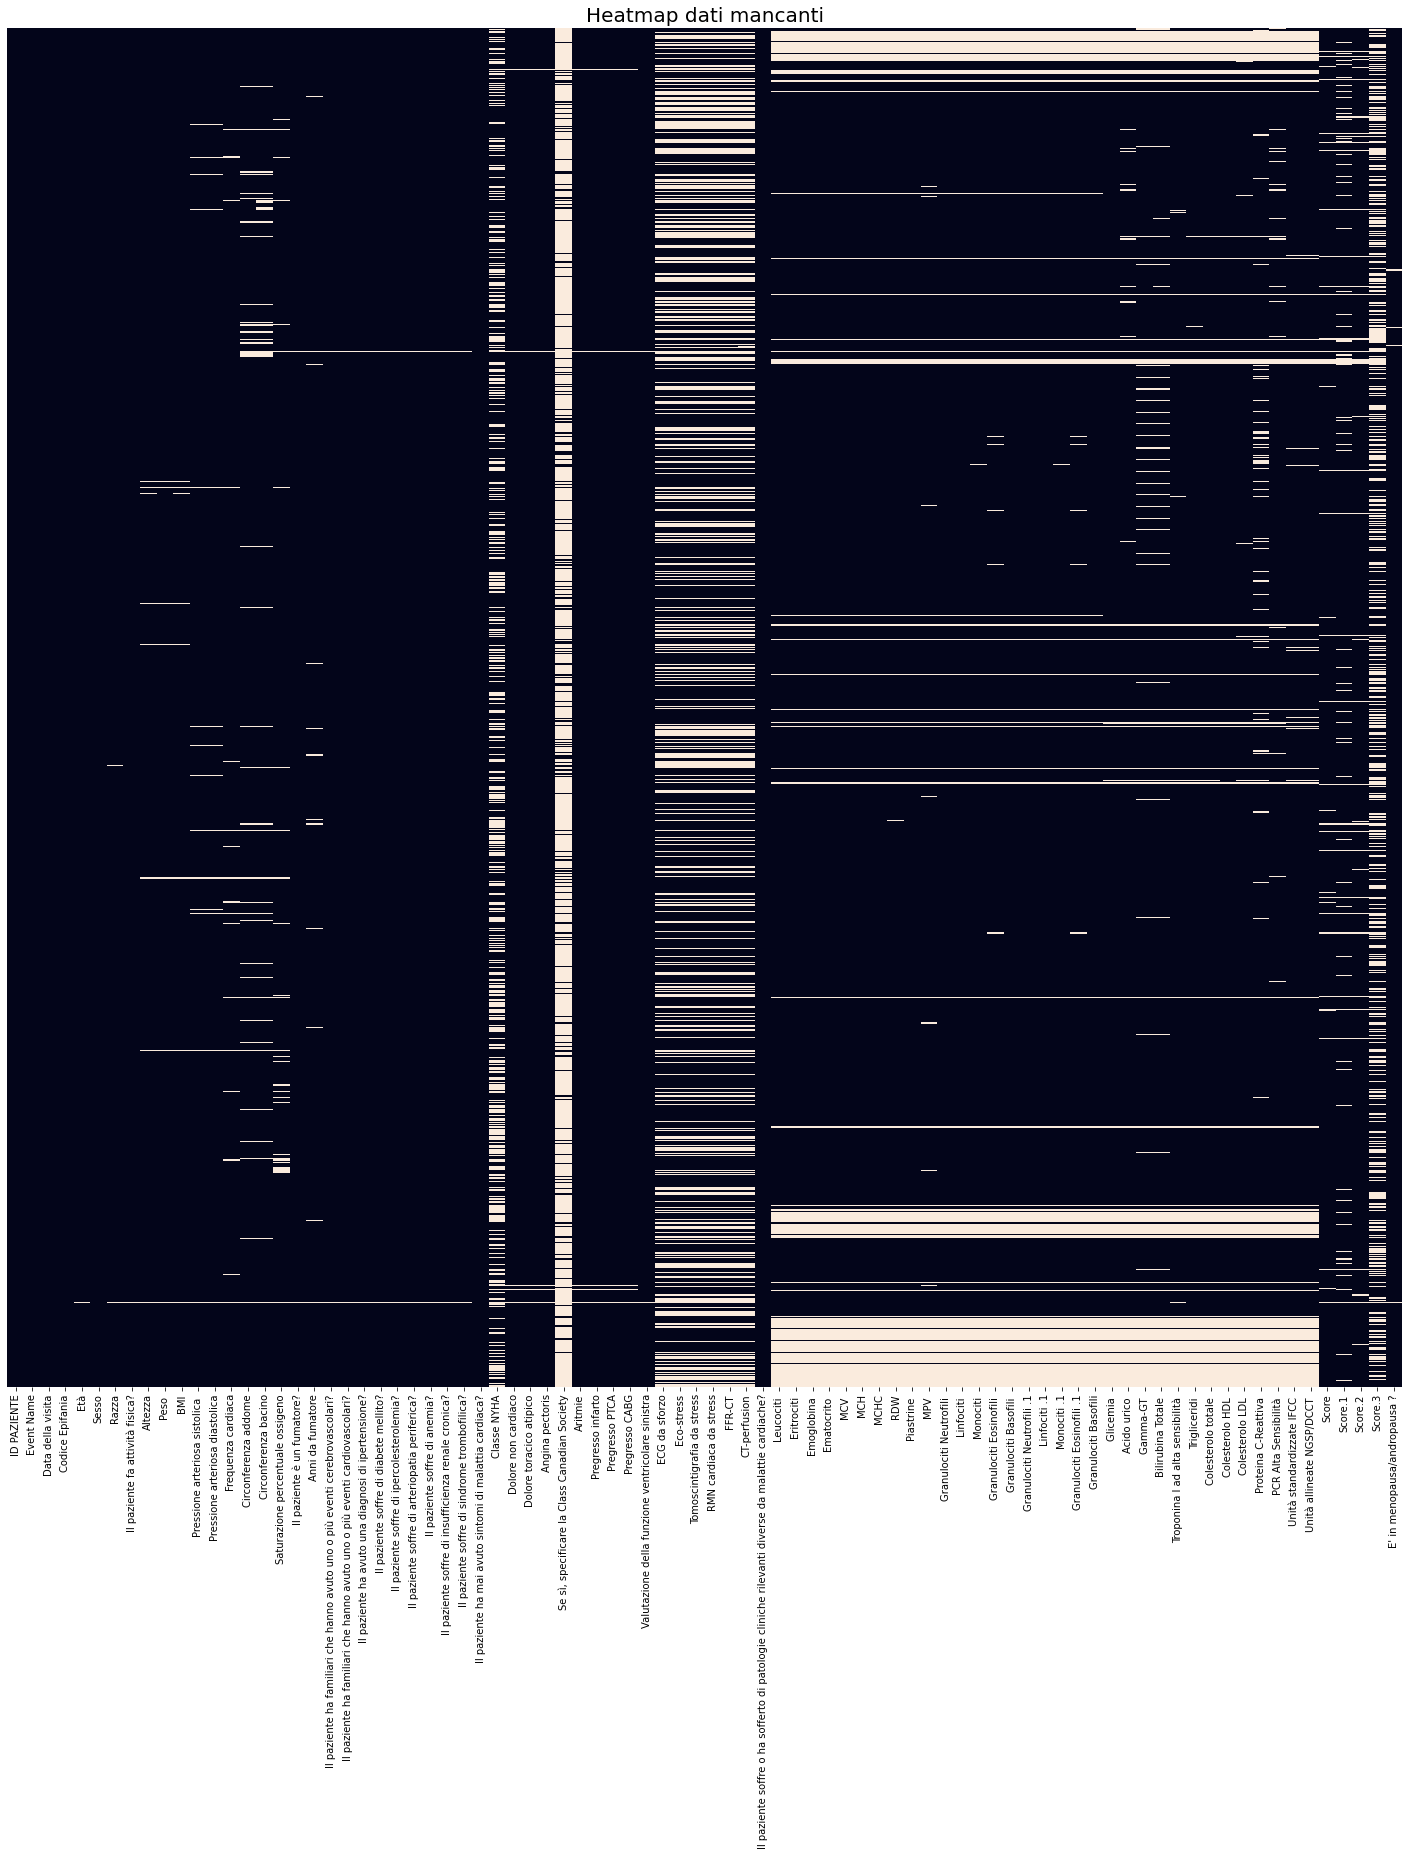

In [7]:
# Visualizzazione dei missing data nel dataset 
#Analisi dati mancanti
plt.figure(figsize=(25,25))
sns.heatmap(dataSet.loc[dataSet["Event Name"]=="Visita 1"].isnull(),yticklabels=False,cbar=False)  #Rilevo velocemente eventuali dati mancanti  
plt.title('Heatmap dati mancanti', fontsize=20)
plt.savefig('HeatmapMissingData.pdf', papertype = 'a0')

In [8]:
#Elimino da subito quelle righe che non hanno la data della visita
missDataVisita = int((dataSet['Data della visita'].isnull().sum()/len(dataSet))*100)
print('Nel dataset mancano il ' + str(missDataVisita) + ' % delle date di visita')

Nel dataset mancano il 4 % delle date di visita


In [9]:
#Estraggo le variabili categoriche
cat_features = dataSet.columns[dataSet.dtypes == 'object']
#Estraggo le variabili continue
cont_features = dataSet.columns[dataSet.dtypes != 'object']

<AxesSubplot:>

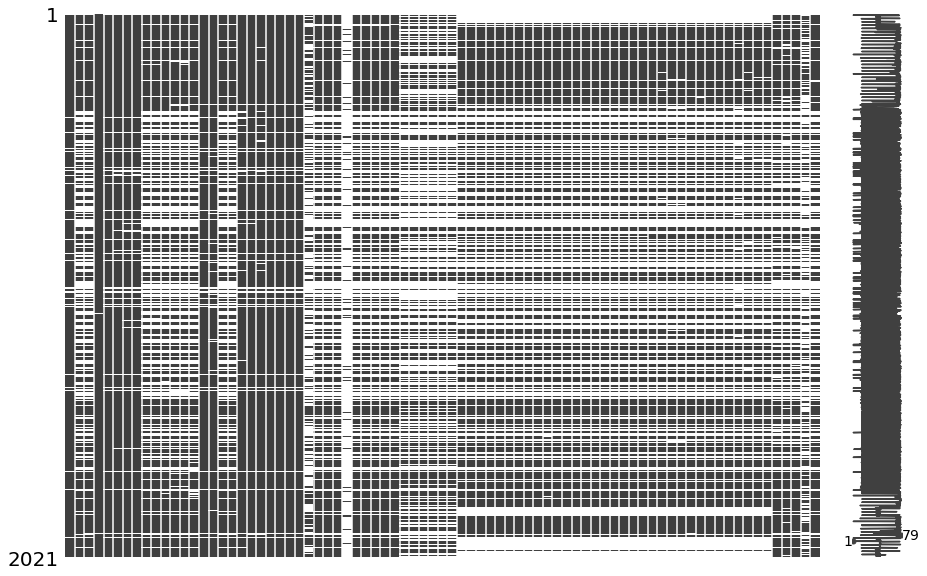

In [10]:
missingdata_df = dataSet.columns[dataSet.isnull().any()].tolist()
msno.matrix(dataSet[missingdata_df], figsize=(15,10)) # Nella parte destra del grafico notiviamo come ci sia una riga in cui mancano 138 elementi 
# e una in cui ne mancano 2

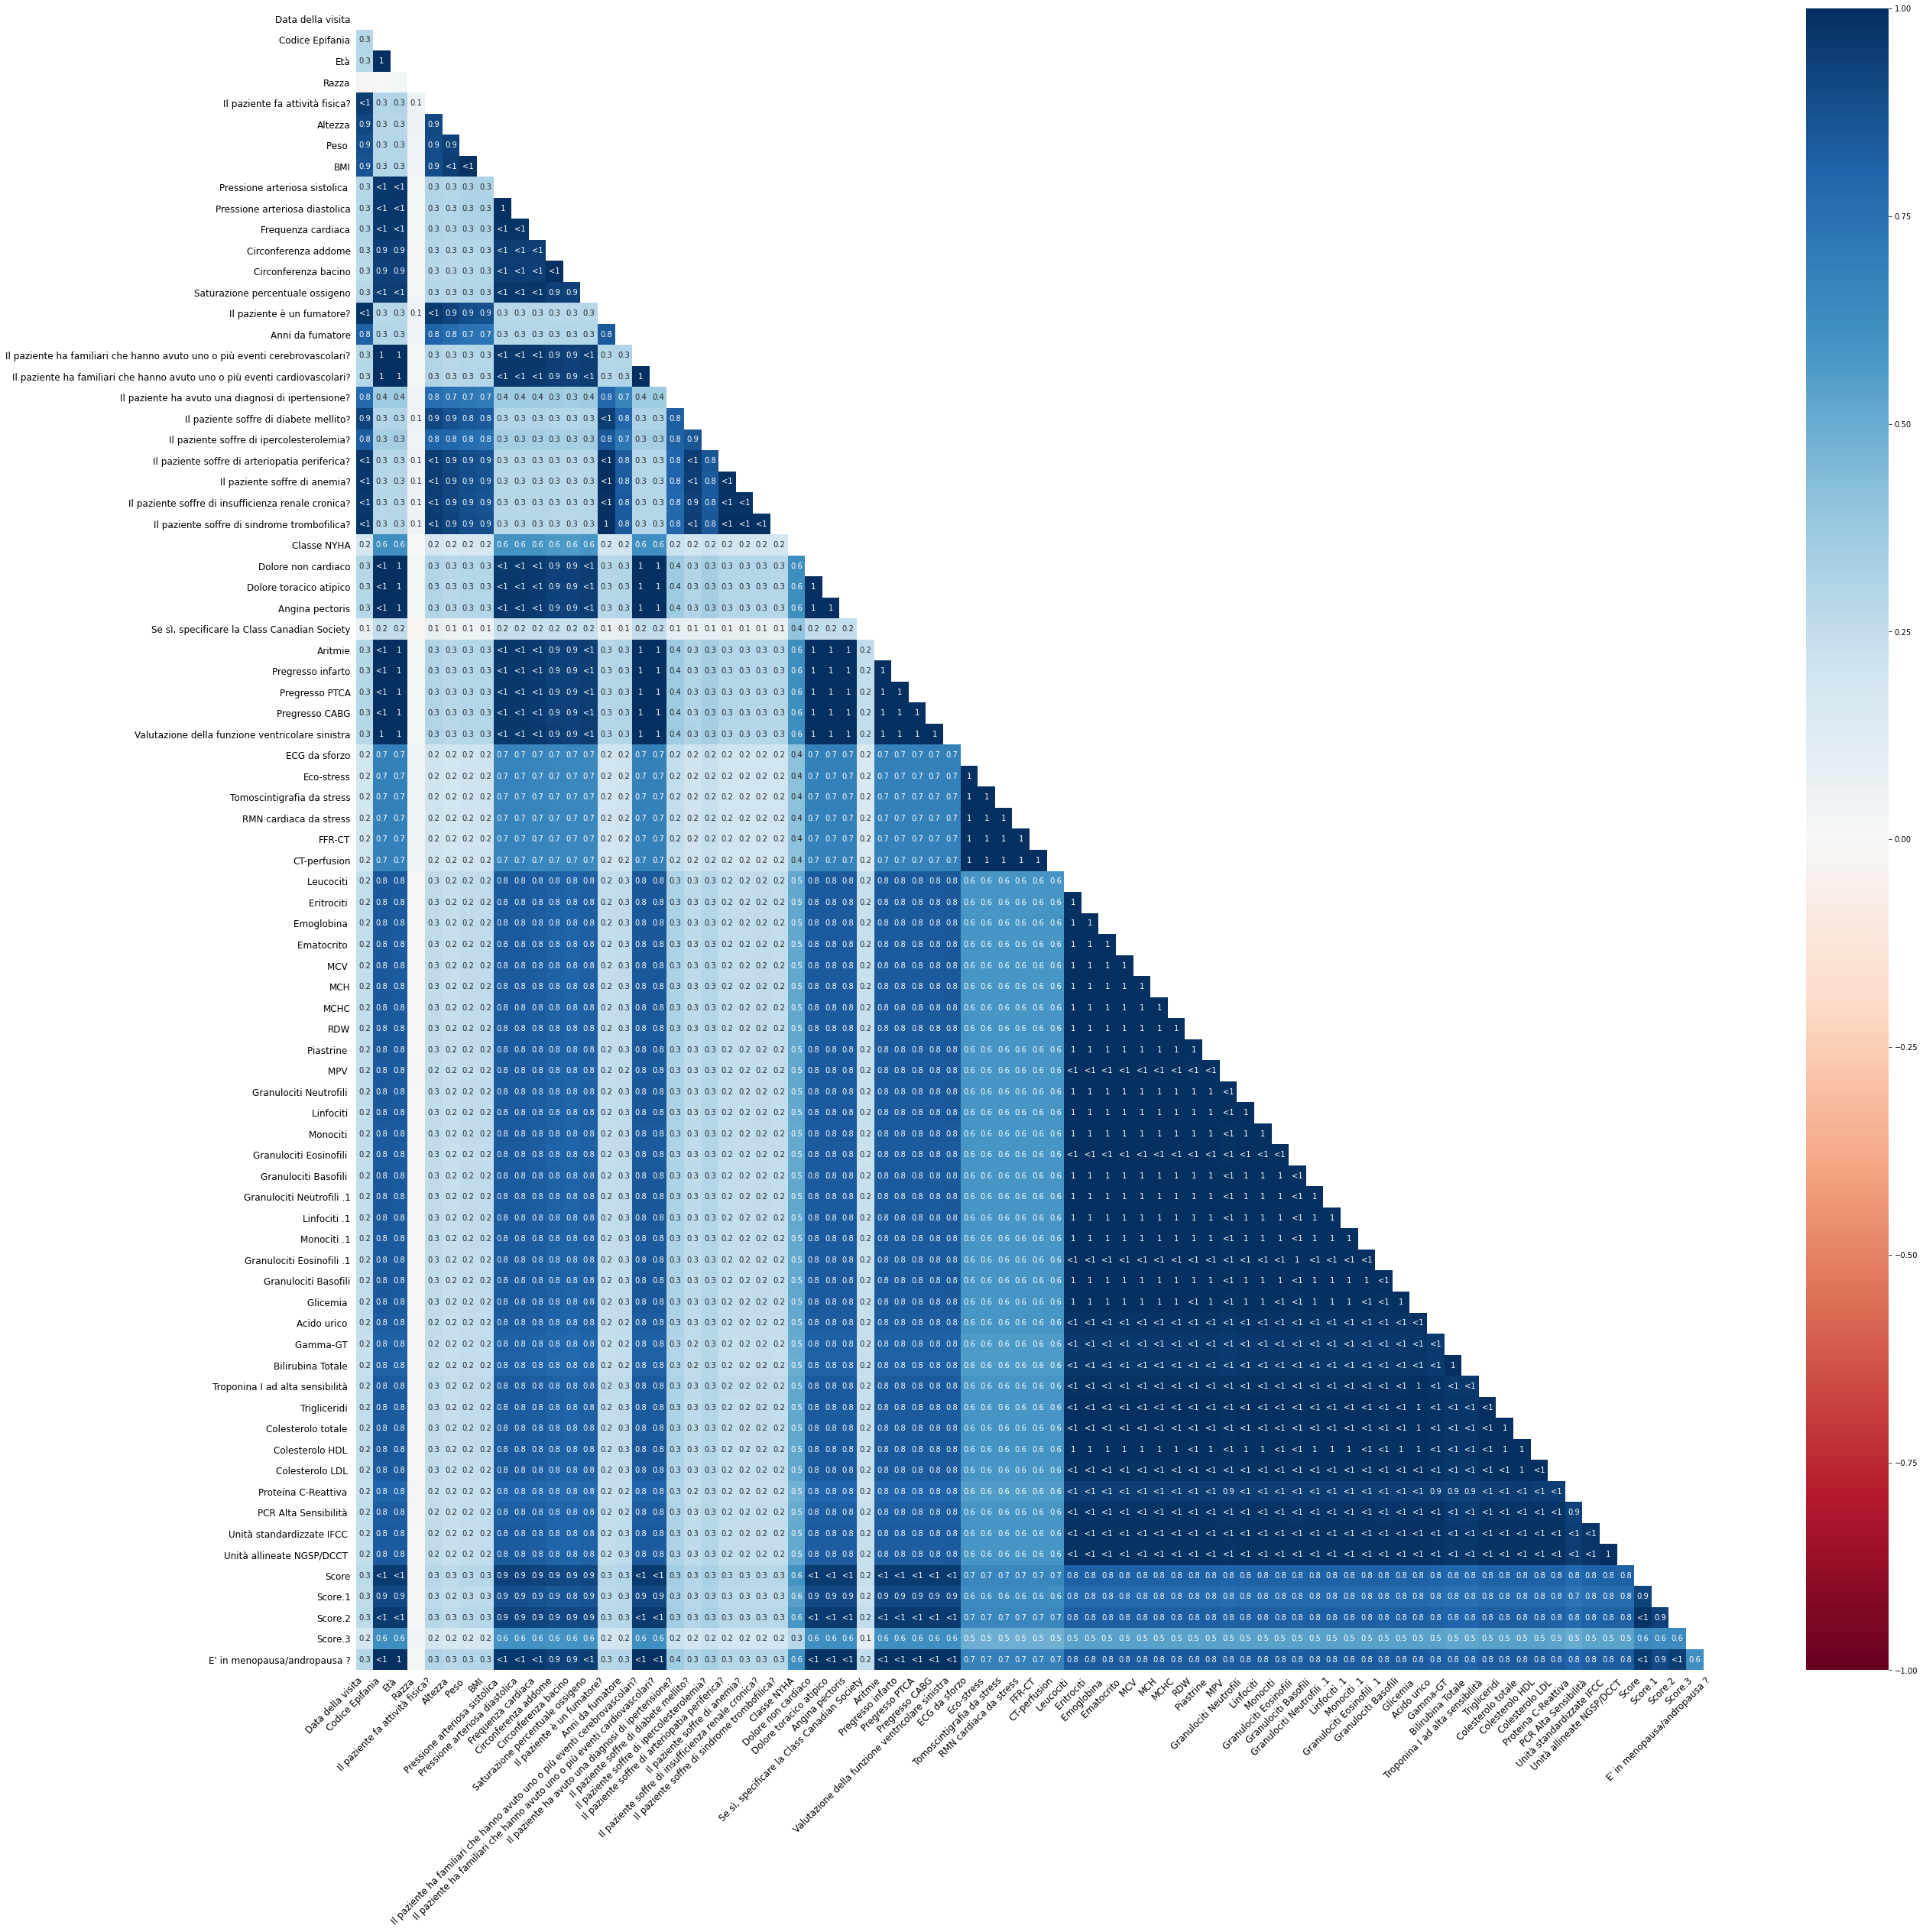

In [11]:
msno.heatmap(dataSet, figsize=(40,40), fontsize=12);

In [12]:
dataSet = read_csv("C:/Users/Antonio Montanaro/Desktop/Tesi Magistrale/File Memory/dataset_Visita1.csv")

#Estraggo le variabili categoriche
cat_features = dataSet.columns[dataSet.dtypes == 'category']
#Estraggo le variabili continue
cont_features = dataSet.columns[dataSet.dtypes != 'category']

Descrizione Età
count    1283.000000
mean       60.028059
std        10.776737
min        18.000000
25%        53.000000
50%        61.000000
75%        69.000000
max        84.000000
Name: Età, dtype: float64

0% of missing Data



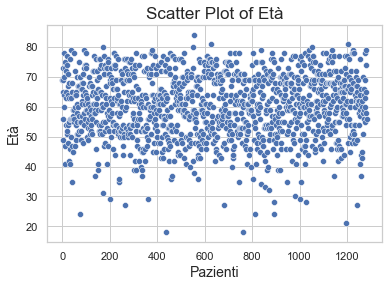

Descrizione Altezza
count    1276.000000
mean      172.118339
std         9.628761
min        96.000000
25%       165.000000
50%       173.000000
75%       180.000000
max       199.000000
Name: Altezza, dtype: float64

0% of missing Data



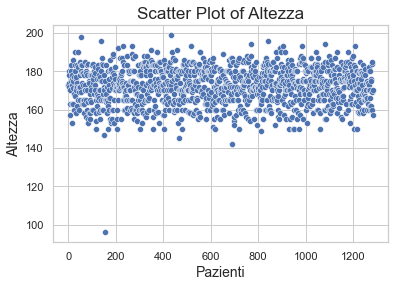

Descrizione Peso 
count    1277.000000
mean       78.447142
std        16.041304
min        43.000000
25%        68.000000
50%        77.000000
75%        88.000000
max       180.000000
Name: Peso , dtype: float64

0% of missing Data



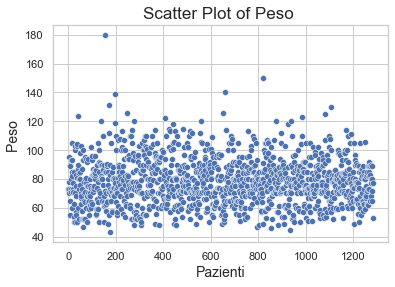

Descrizione BMI
count    1276.000000
mean       26.451004
std         6.441652
min        16.415307
25%        23.456790
50%        25.711930
75%        28.719813
max       195.312500
Name: BMI, dtype: float64

0% of missing Data



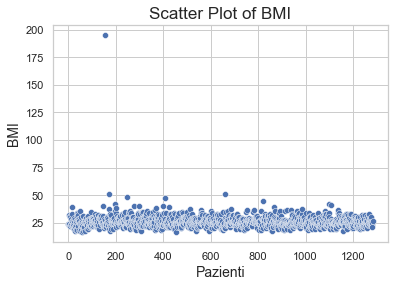

Descrizione Pressione arteriosa sistolica 
count    1270.000000
mean      141.037008
std        19.152765
min        90.000000
25%       130.000000
50%       140.000000
75%       152.000000
max       226.000000
Name: Pressione arteriosa sistolica , dtype: float64

1% of missing Data



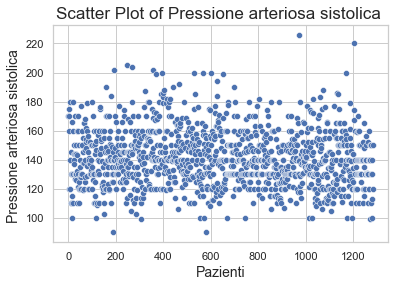

Descrizione Pressione arteriosa diastolica
count    1270.000000
mean       81.909449
std        11.213755
min        41.000000
25%        75.000000
50%        80.000000
75%        90.000000
max       130.000000
Name: Pressione arteriosa diastolica, dtype: float64

1% of missing Data



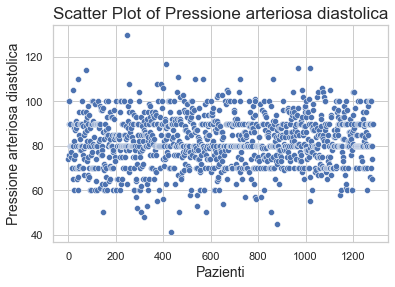

Descrizione Frequenza cardiaca
count    1264.000000
mean       71.659810
std        13.224169
min         0.000000
25%        62.000000
50%        70.000000
75%        79.000000
max       145.000000
Name: Frequenza cardiaca, dtype: float64

1% of missing Data



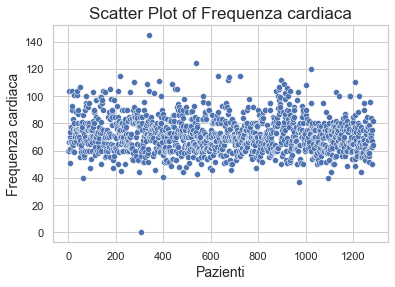

Descrizione Circonferenza addome
count    1240.000000
mean       96.225806
std        14.286438
min        54.000000
25%        86.000000
50%        96.000000
75%       105.000000
max       175.000000
Name: Circonferenza addome, dtype: float64

3% of missing Data



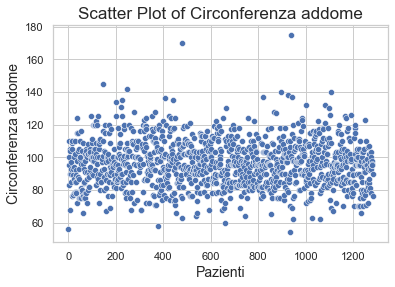

Descrizione Circonferenza bacino
count    1235.000000
mean      101.021862
std        11.435054
min        48.000000
25%        94.000000
50%       101.000000
75%       108.000000
max       147.000000
Name: Circonferenza bacino, dtype: float64

3% of missing Data



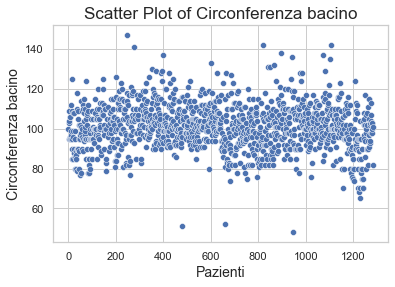

Descrizione Saturazione percentuale ossigeno
count    1252.000000
mean       97.714058
std         1.623083
min        85.000000
25%        97.000000
50%        98.000000
75%        99.000000
max       100.000000
Name: Saturazione percentuale ossigeno, dtype: float64

2% of missing Data



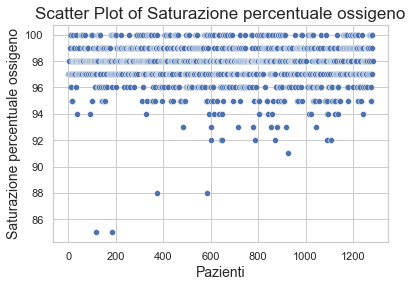

Descrizione Anni da fumatore
count     1271
unique      45
top          0
freq       596
Name: Anni da fumatore, dtype: object

1% of missing Data



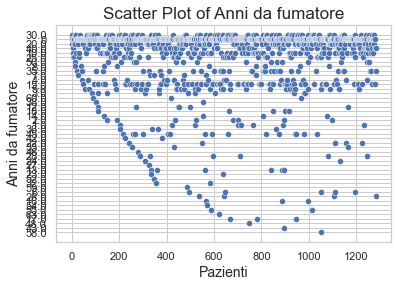

Descrizione Leucociti 
count    1138.000000
mean        7.759227
std         1.950479
min         4.000000
25%         6.400000
50%         7.400000
75%         8.800000
max        18.500000
Name: Leucociti , dtype: float64

11% of missing Data



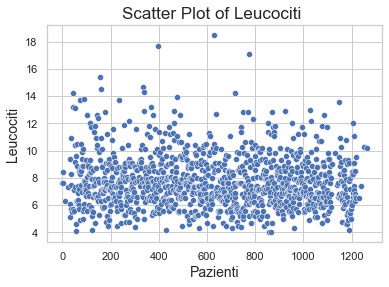

Descrizione Eritrociti 
count    1138.00000
mean        4.87283
std         0.46992
min         2.76000
25%         4.58000
50%         4.88000
75%         5.17000
max         6.99000
Name: Eritrociti , dtype: float64

11% of missing Data



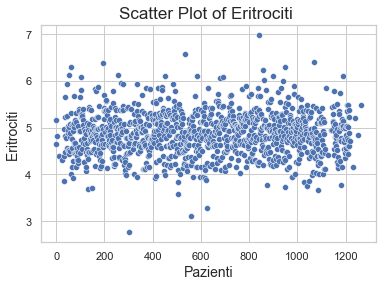

Descrizione Emoglobina 
count    1138.000000
mean       14.491599
std         1.334336
min         9.000000
25%        13.700000
50%        14.600000
75%        15.400000
max        18.400000
Name: Emoglobina , dtype: float64

11% of missing Data



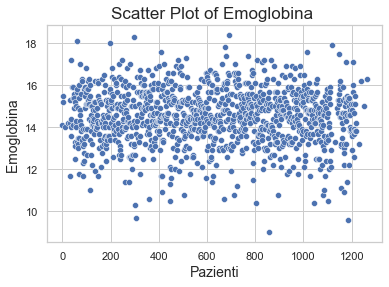

Descrizione Ematocrito 
count    1138.000000
mean       42.265448
std         3.498935
min        28.900000
25%        40.200000
50%        42.400000
75%        44.600000
max        54.100000
Name: Ematocrito , dtype: float64

11% of missing Data



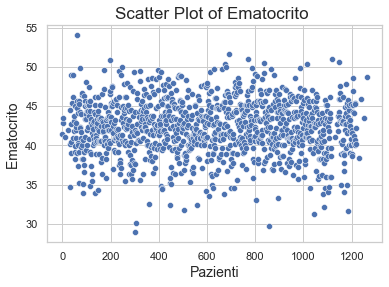

Descrizione MCV 
count    1138.000000
mean       87.611687
std        22.887048
min         4.800000
25%        84.800000
50%        87.500000
75%        89.800000
max       834.000000
Name: MCV , dtype: float64

11% of missing Data



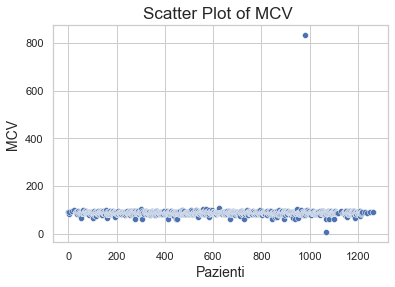

Descrizione MCH
count    1138.000000
mean       29.836054
std         2.158192
min        18.600000
25%        29.000000
50%        30.100000
75%        31.000000
max        39.400000
Name: MCH, dtype: float64

11% of missing Data



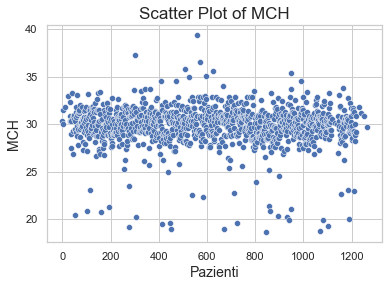

Descrizione MCHC
count    1138.000000
mean       34.270747
std         1.041380
min        30.300000
25%        33.600000
50%        34.300000
75%        34.900000
max        38.000000
Name: MCHC, dtype: float64

11% of missing Data



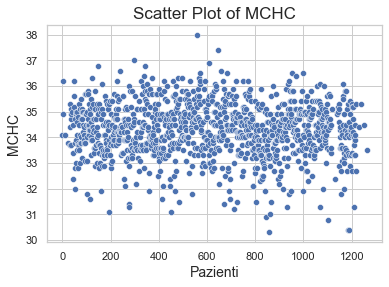

Descrizione RDW
count    1137.000000
mean       13.071434
std         1.050150
min        11.100000
25%        12.500000
50%        12.900000
75%        13.400000
max        20.800000
Name: RDW, dtype: float64

11% of missing Data



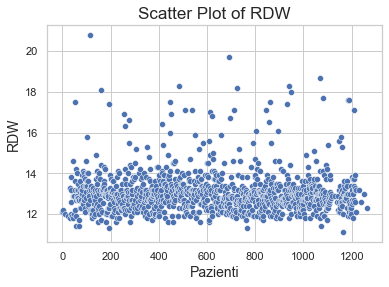

Descrizione Piastrine 
count    1138.000000
mean      236.407733
std        54.166336
min        39.000000
25%       199.000000
50%       230.000000
75%       269.000000
max       489.000000
Name: Piastrine , dtype: float64

11% of missing Data



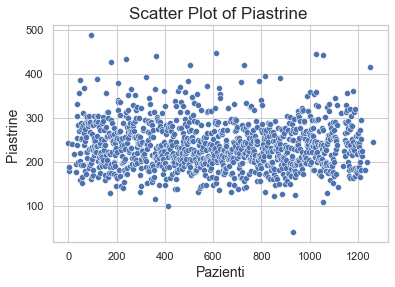

Descrizione MPV 
count    1131.000000
mean       10.469938
std         1.525807
min         6.500000
25%         9.800000
50%        10.400000
75%        11.000000
max        52.300000
Name: MPV , dtype: float64

11% of missing Data



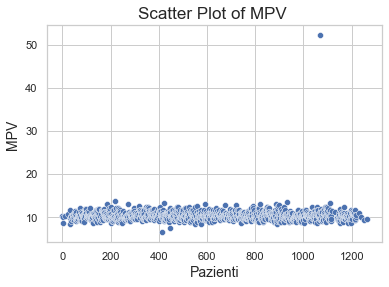

Descrizione Granulociti Neutrofili 
count    1138.000000
mean       60.749753
std        10.392816
min        14.857143
25%        54.293831
50%        59.863889
75%        66.052304
max        95.775862
Name: Granulociti Neutrofili , dtype: float64

11% of missing Data



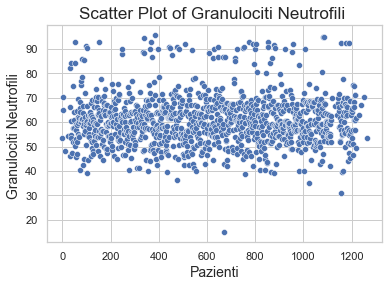

Descrizione Linfociti 
count    1138.000000
mean       29.411500
std         8.676139
min         3.448276
25%        24.218501
50%        29.787234
75%        34.984940
max        56.716418
Name: Linfociti , dtype: float64

11% of missing Data



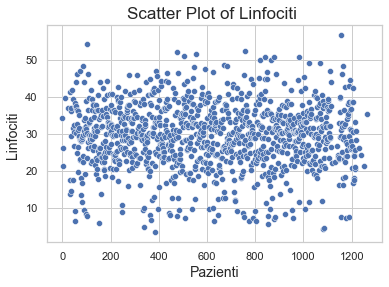

Descrizione Monociti 
count    1137.000000
mean        7.428775
std         2.296135
min         0.000000
25%         6.329114
50%         7.500000
75%         8.771930
max        14.545455
Name: Monociti , dtype: float64

11% of missing Data



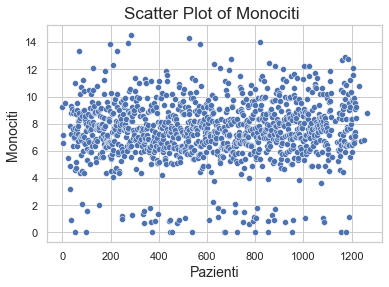

Descrizione Granulociti Eosinofili 
count    1133.000000
mean        1.915295
std         2.521733
min         0.000000
25%         0.847458
50%         1.505376
75%         2.500000
max        70.428571
Name: Granulociti Eosinofili , dtype: float64

11% of missing Data



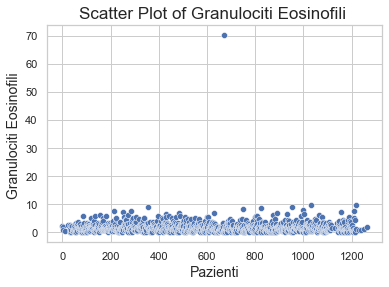

Descrizione Granulociti Basofili 
count    1138.000000
mean        0.562708
std         2.773225
min         0.000000
25%         0.000000
50%         0.000000
75%         1.123596
max        91.489362
Name: Granulociti Basofili , dtype: float64

11% of missing Data



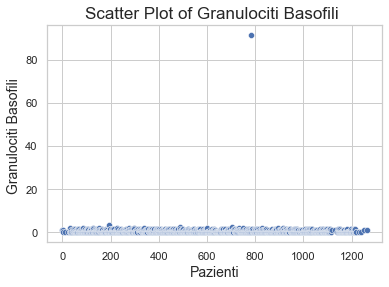

Descrizione Granulociti Neutrofili .1
count    1138.000000
mean        4.790879
std         1.802235
min         1.040000
25%         3.620000
50%         4.430000
75%         5.470000
max        16.610000
Name: Granulociti Neutrofili .1, dtype: float64

11% of missing Data



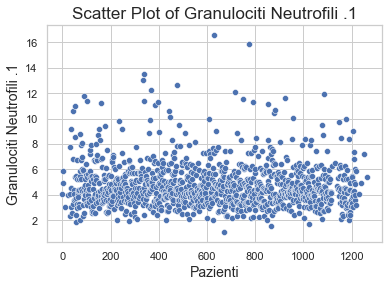

Descrizione Linfociti .1
count    1138.000000
mean        2.222206
std         0.741386
min         0.400000
25%         1.800000
50%         2.200000
75%         2.600000
max         5.300000
Name: Linfociti .1, dtype: float64

11% of missing Data



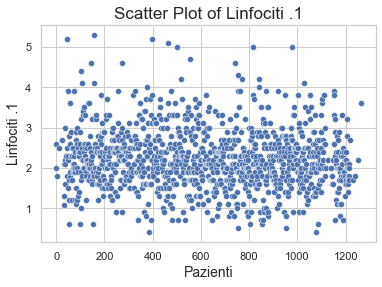

Descrizione Monociti .1
count    1137.000000
mean        0.562181
std         0.199590
min         0.000000
25%         0.400000
50%         0.600000
75%         0.700000
max         1.400000
Name: Monociti .1, dtype: float64

11% of missing Data



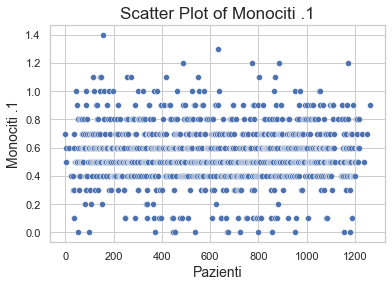

Descrizione Granulociti Eosinofili .1
count    1133.00000
mean        0.14549
std         0.18644
min         0.00000
25%         0.06000
50%         0.11000
75%         0.19000
max         4.93000
Name: Granulociti Eosinofili .1, dtype: float64

11% of missing Data



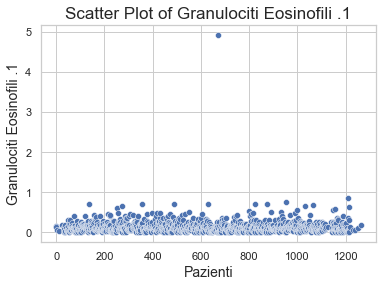

Descrizione Granulociti Basofili
count    1138.000000
mean        0.042355
std         0.135898
min         0.000000
25%         0.000000
50%         0.000000
75%         0.100000
max         4.300000
Name: Granulociti Basofili, dtype: float64

11% of missing Data



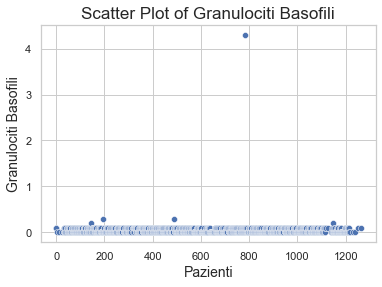

Descrizione Glicemia 
count    1138.000000
mean      102.742531
std        24.128496
min        29.000000
25%        91.000000
50%        97.000000
75%       105.000000
max       353.000000
Name: Glicemia , dtype: float64

11% of missing Data



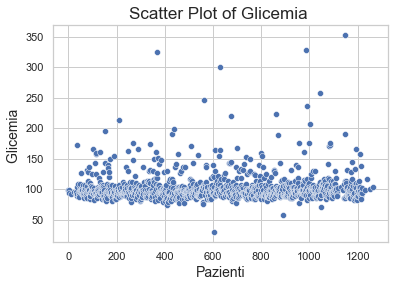

Descrizione Acido urico 
count    1125.000000
mean        5.285342
std         1.326235
min         1.800000
25%         4.300000
50%         5.300000
75%         6.200000
max        10.200000
Name: Acido urico , dtype: float64

12% of missing Data



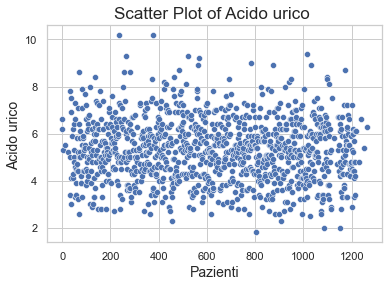

Descrizione Gamma-GT 
count    1109.000000
mean       31.481515
std        25.740072
min         7.000000
25%        18.000000
50%        24.000000
75%        35.000000
max       340.000000
Name: Gamma-GT , dtype: float64

13% of missing Data



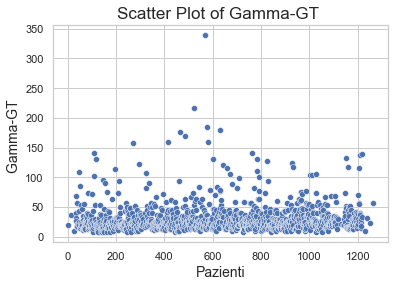

Descrizione Bilirubina Totale 
count    1107.000000
mean        0.749548
std         0.719582
min         0.140000
25%         0.480000
50%         0.640000
75%         0.860000
max        20.520000
Name: Bilirubina Totale , dtype: float64

13% of missing Data



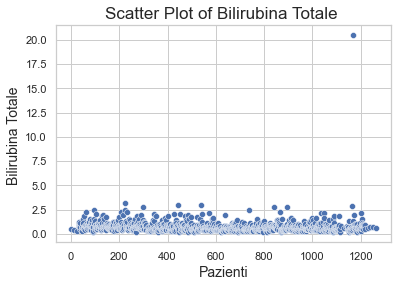

Descrizione Troponina I ad alta sensibilità 
count    1134.000000
mean        6.207584
std        31.534423
min         0.000000
25%         1.500000
50%         2.500000
75%         4.200000
max       897.600000
Name: Troponina I ad alta sensibilità , dtype: float64

11% of missing Data



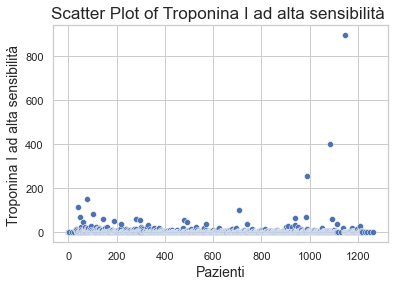

Descrizione Trigliceridi 
count    1136.000000
mean      105.330238
std        55.897795
min         0.430000
25%        69.000000
50%        92.000000
75%       126.000000
max       518.000000
Name: Trigliceridi , dtype: float64

11% of missing Data



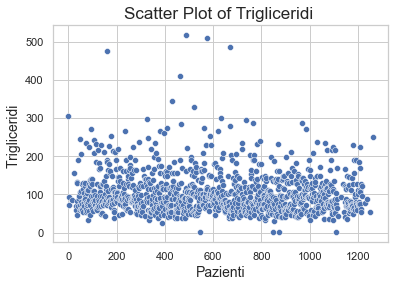

Descrizione Colesterolo totale 
count    1137.000000
mean      195.116974
std        39.042864
min         1.100000
25%       171.000000
50%       194.000000
75%       221.000000
max       339.000000
Name: Colesterolo totale , dtype: float64

11% of missing Data



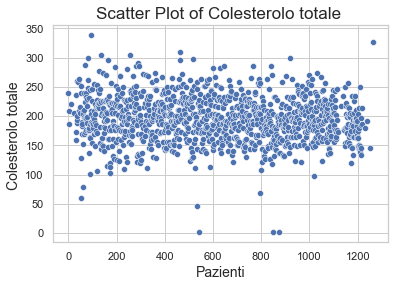

Descrizione Colesterolo HDL 
count    1138.000000
mean       58.096924
std        16.006678
min         2.300000
25%        46.775000
50%        56.000000
75%        67.400000
max       129.000000
Name: Colesterolo HDL , dtype: float64

11% of missing Data



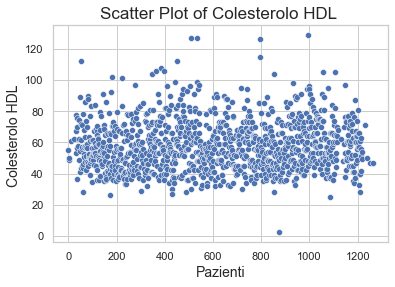

Descrizione Colesterolo LDL 
count    1133.000000
mean      117.284987
std        44.027002
min         0.890000
25%        95.000000
50%       115.000000
75%       137.000000
max      1111.000000
Name: Colesterolo LDL , dtype: float64

11% of missing Data



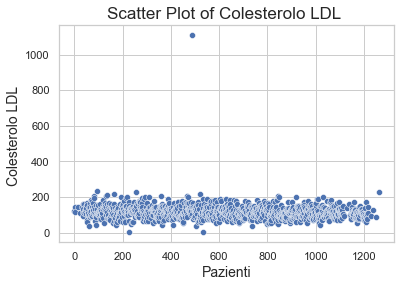

Descrizione Proteina C-Reattiva 
count    1090.000000
mean        2.300394
std         8.201275
min         0.000000
25%         0.500000
50%         0.900000
75%         1.975000
max       206.000000
Name: Proteina C-Reattiva , dtype: float64

15% of missing Data



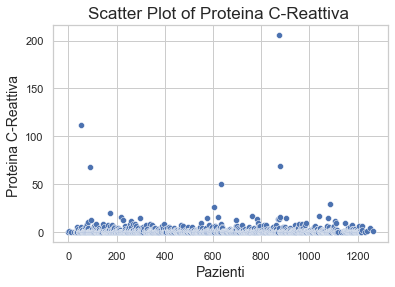

Descrizione PCR Alta Sensibilità 
count    1121.000000
mean        2.402516
std         6.870149
min         0.070000
25%         0.610000
50%         1.120000
75%         2.230000
max       143.000000
Name: PCR Alta Sensibilità , dtype: float64

12% of missing Data



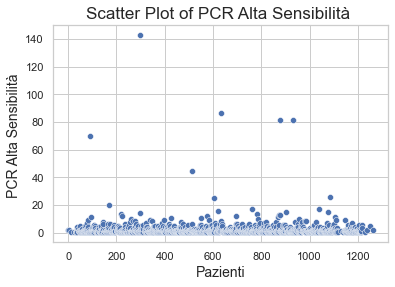

Descrizione Unità standardizzate IFCC 
count    1132.000000
mean       38.794346
std         7.661099
min         5.200000
25%        35.000000
50%        38.000000
75%        40.000000
max       104.000000
Name: Unità standardizzate IFCC , dtype: float64

11% of missing Data



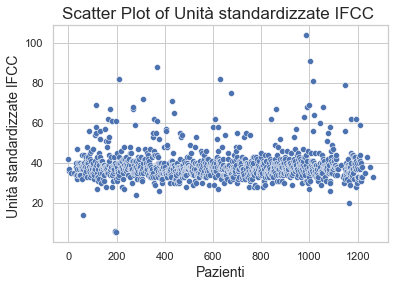

Descrizione Unità allineate NGSP/DCCT 
count    1132.000000
mean        5.772580
std         1.688384
min         0.500000
25%         5.400000
50%         5.600000
75%         5.800000
max        38.000000
Name: Unità allineate NGSP/DCCT , dtype: float64

11% of missing Data



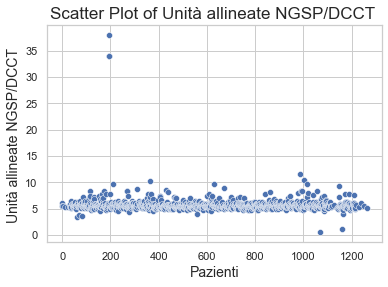

Descrizione Score
count    1242.000000
mean        7.654589
std         1.824451
min         3.000000
25%         6.000000
50%         8.000000
75%         9.000000
max        13.000000
Name: Score, dtype: float64

3% of missing Data



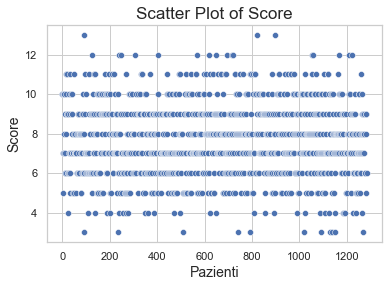

Descrizione Score.1
count    1187.000000
mean       11.368155
std         5.167197
min         7.000000
25%         8.000000
50%         9.000000
75%        13.000000
max        39.000000
Name: Score.1, dtype: float64

7% of missing Data



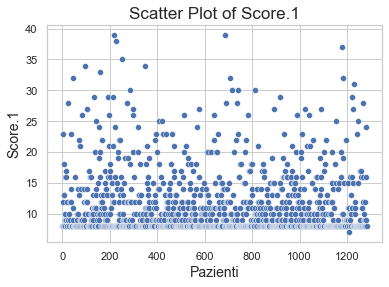

Descrizione Score.2
count    1240.000000
mean        4.987903
std         5.203434
min         0.000000
25%         1.000000
50%         3.000000
75%         7.000000
max        30.000000
Name: Score.2, dtype: float64

3% of missing Data



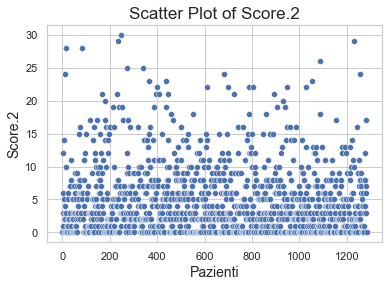

Descrizione Score.3
count    813.000000
mean      18.019680
std        7.364848
min        0.000000
25%       16.000000
50%       20.000000
75%       24.000000
max       25.000000
Name: Score.3, dtype: float64

36% of missing Data



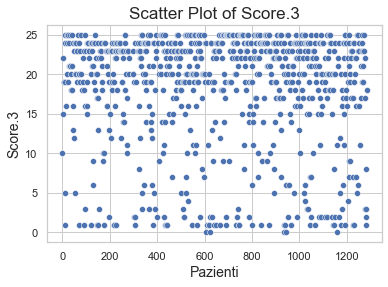

Descrizione ID PAZIENTE
count     1284
unique    1284
top          1
freq         1
Name: ID PAZIENTE, dtype: object

0% of missing Data



<Figure size 432x288 with 0 Axes>

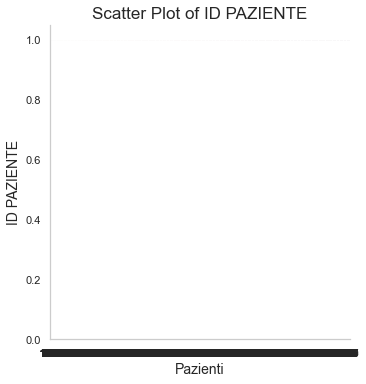

Descrizione Event Name
count         1284
unique           1
top       Visita 1
freq          1284
Name: Event Name, dtype: object

0% of missing Data



<Figure size 432x288 with 0 Axes>

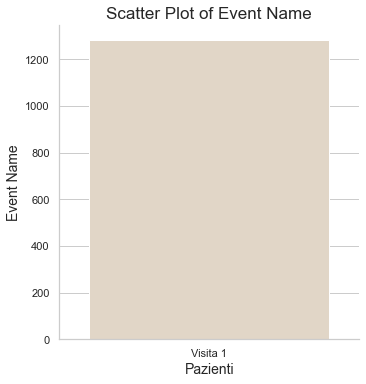

Descrizione Data della visita
count           1284
unique           540
top       2016-10-11
freq               7
Name: Data della visita, dtype: object

0% of missing Data



<Figure size 432x288 with 0 Axes>

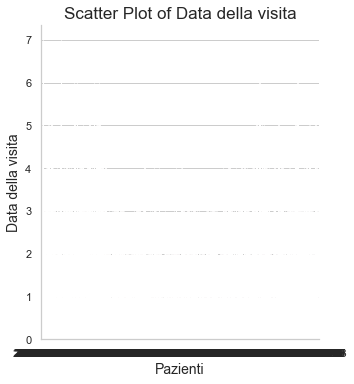

Descrizione Codice Epifania
count        1284
unique       1283
top       EP00983
freq            2
Name: Codice Epifania, dtype: object

0% of missing Data



<Figure size 432x288 with 0 Axes>

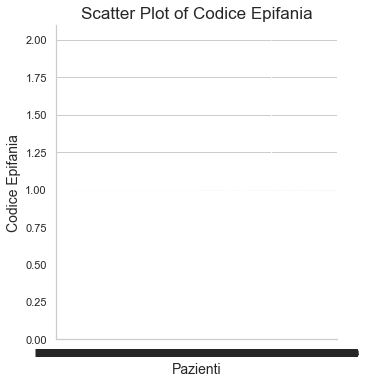

Descrizione Sesso
count     1284
unique       2
top          0
freq       881
Name: Sesso, dtype: object

0% of missing Data



<Figure size 432x288 with 0 Axes>

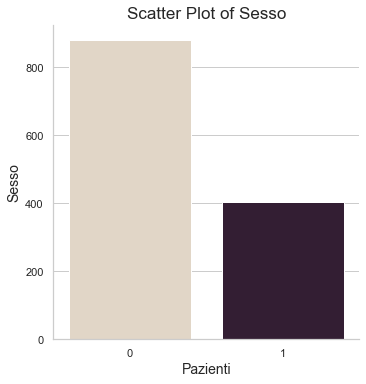

Descrizione Razza
count     1282
unique       5
top          0
freq      1266
Name: Razza, dtype: object

0% of missing Data



<Figure size 432x288 with 0 Axes>

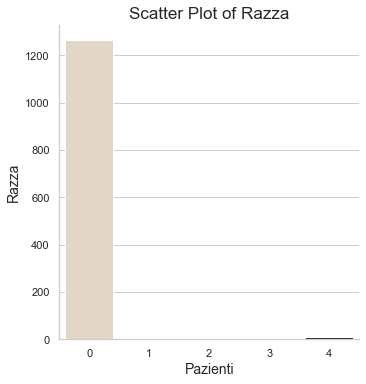

Descrizione Il paziente fa attività fisica?
count     1283
unique       4
top          1
freq       491
Name: Il paziente fa attività fisica?, dtype: object

0% of missing Data



<Figure size 432x288 with 0 Axes>

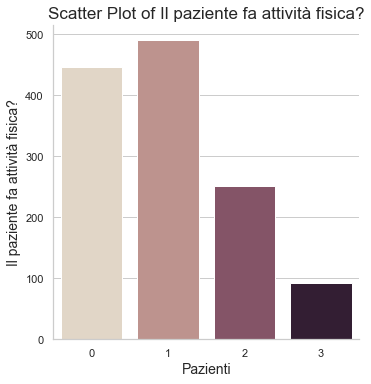

Descrizione Il paziente è un fumatore?
count     1282
unique       3
top          0
freq       596
Name: Il paziente è un fumatore?, dtype: object

0% of missing Data



<Figure size 432x288 with 0 Axes>

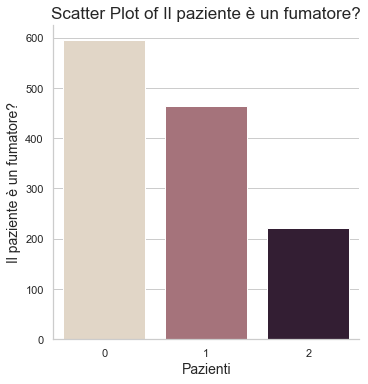

Descrizione Il paziente ha familiari che hanno avuto uno o più eventi cerebrovascolari?
count     1282
unique       2
top          0
freq       973
Name: Il paziente ha familiari che hanno avuto uno o più eventi cerebrovascolari?, dtype: object

0% of missing Data



<Figure size 432x288 with 0 Axes>

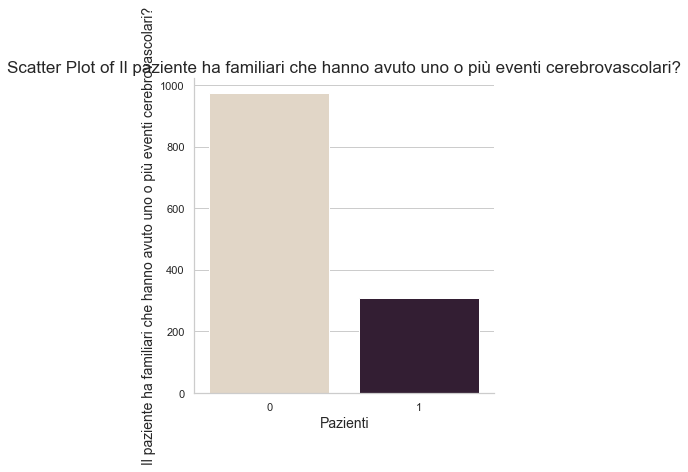

Descrizione Il paziente ha familiari che hanno avuto uno o più eventi cardiovascolari?
count     1282
unique       2
top          0
freq       642
Name: Il paziente ha familiari che hanno avuto uno o più eventi cardiovascolari?, dtype: object

0% of missing Data



<Figure size 432x288 with 0 Axes>

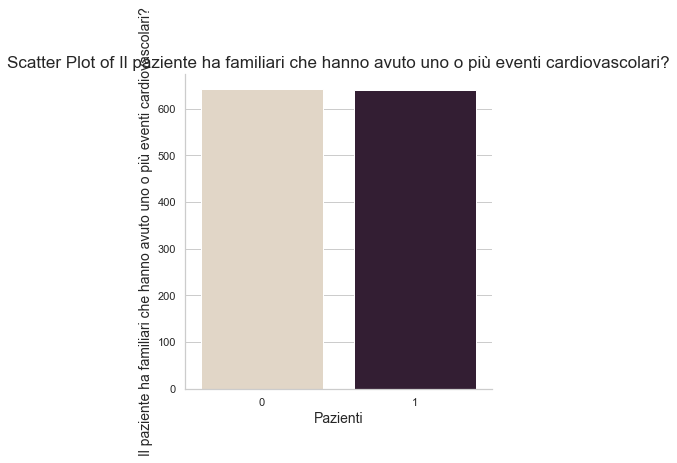

Descrizione Il paziente ha avuto una diagnosi di ipertensione?
count     1282
unique       2
top          1
freq       674
Name: Il paziente ha avuto una diagnosi di ipertensione?, dtype: object

0% of missing Data



<Figure size 432x288 with 0 Axes>

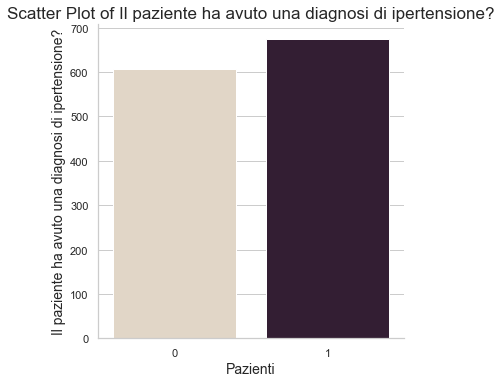

Descrizione Il paziente soffre di diabete mellito?
count     1282
unique       2
top          0
freq      1153
Name: Il paziente soffre di diabete mellito?, dtype: object

0% of missing Data



<Figure size 432x288 with 0 Axes>

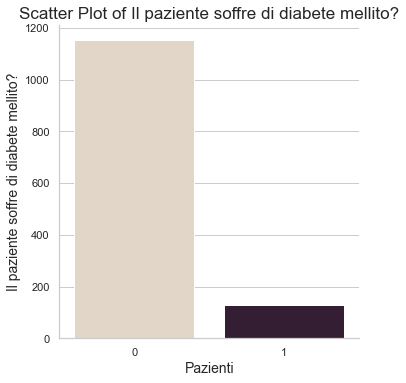

Descrizione Il paziente soffre di ipercolesterolemia?
count     1282
unique       2
top          1
freq       709
Name: Il paziente soffre di ipercolesterolemia?, dtype: object

0% of missing Data



<Figure size 432x288 with 0 Axes>

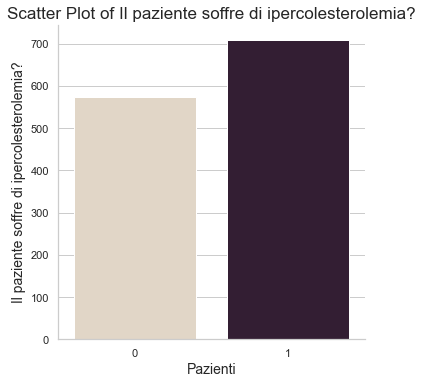

Descrizione Il paziente soffre di arteriopatia periferica?
count     1282
unique       2
top          0
freq      1186
Name: Il paziente soffre di arteriopatia periferica?, dtype: object

0% of missing Data



<Figure size 432x288 with 0 Axes>

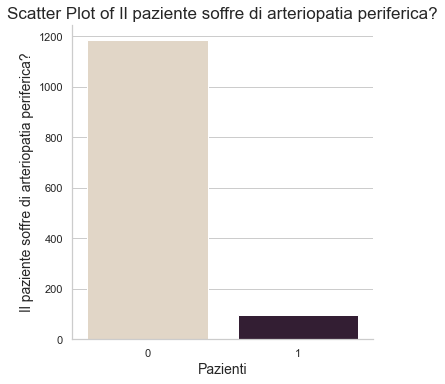

Descrizione Il paziente soffre di anemia?
count     1282
unique       2
top          0
freq      1239
Name: Il paziente soffre di anemia?, dtype: object

0% of missing Data



<Figure size 432x288 with 0 Axes>

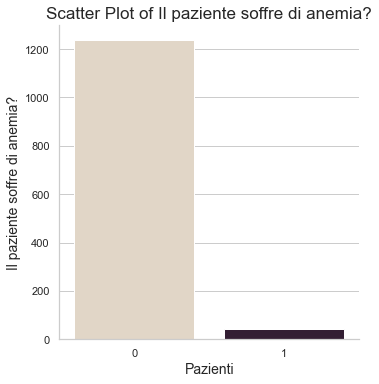

Descrizione Il paziente soffre di insufficienza renale cronica?
count     1282
unique       2
top          0
freq      1274
Name: Il paziente soffre di insufficienza renale cronica?, dtype: object

0% of missing Data



<Figure size 432x288 with 0 Axes>

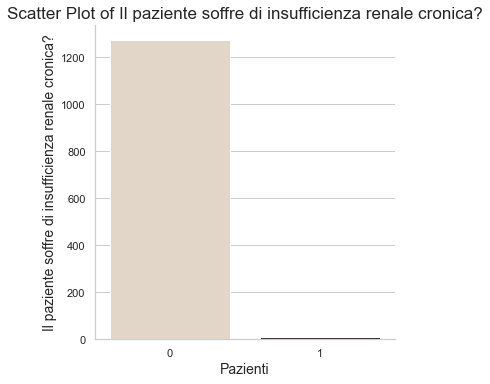

Descrizione Il paziente soffre di sindrome trombofilica?
count     1282
unique       2
top          0
freq      1263
Name: Il paziente soffre di sindrome trombofilica?, dtype: object

0% of missing Data



<Figure size 432x288 with 0 Axes>

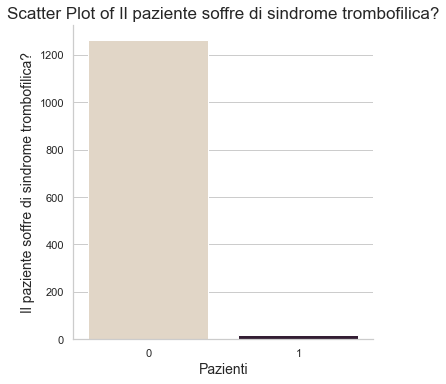

Descrizione Il paziente ha mai avuto sintomi di malattia cardiaca?
count     1284
unique       2
top          1
freq       818
Name: Il paziente ha mai avuto sintomi di malattia cardiaca?, dtype: object

0% of missing Data



<Figure size 432x288 with 0 Axes>

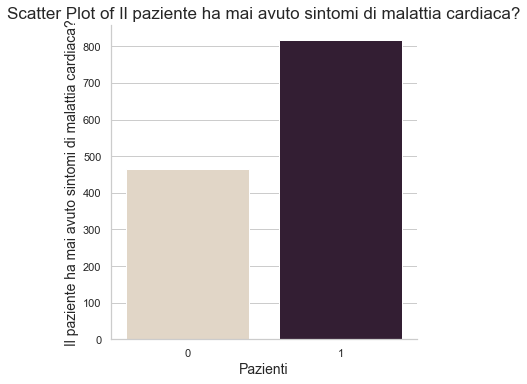

Descrizione Classe NYHA
count     812
unique      4
top       0.0
freq      471
Name: Classe NYHA, dtype: object

36% of missing Data



<Figure size 432x288 with 0 Axes>

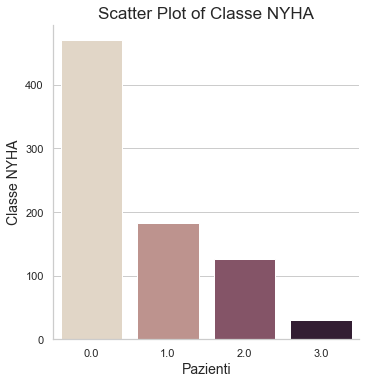

Descrizione Dolore non cardiaco
count     1279
unique       2
top          0
freq      1162
Name: Dolore non cardiaco, dtype: object

0% of missing Data



<Figure size 432x288 with 0 Axes>

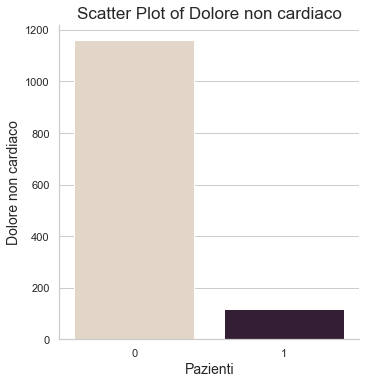

Descrizione Dolore toracico atipico
count     1279
unique       2
top          0
freq       988
Name: Dolore toracico atipico, dtype: object

0% of missing Data



<Figure size 432x288 with 0 Axes>

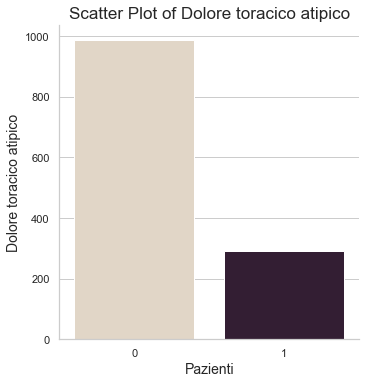

Descrizione Angina pectoris
count     1279
unique       2
top          0
freq      1080
Name: Angina pectoris, dtype: object

0% of missing Data



<Figure size 432x288 with 0 Axes>

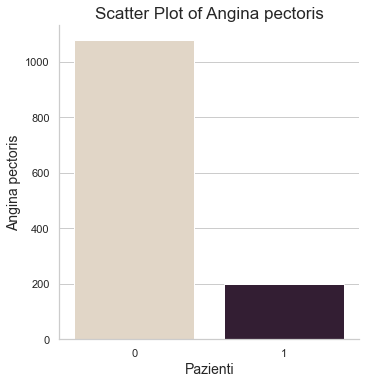

Descrizione Se sì, specificare la Class Canadian Society
count     194
unique      5
top       1.0
freq       74
Name: Se sì, specificare la Class Canadian Society, dtype: object

84% of missing Data



<Figure size 432x288 with 0 Axes>

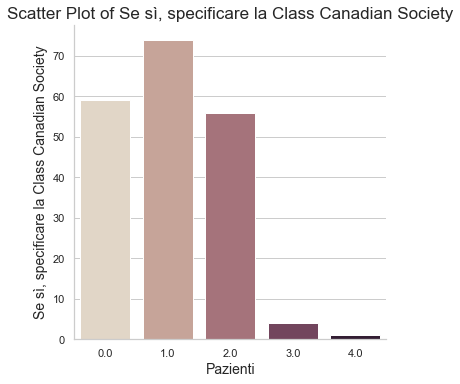

Descrizione Aritmie
count     1279
unique       2
top          0
freq      1004
Name: Aritmie, dtype: object

0% of missing Data



<Figure size 432x288 with 0 Axes>

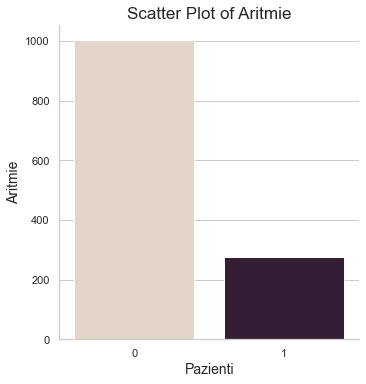

Descrizione Pregresso infarto
count     1279
unique       2
top          0
freq      1278
Name: Pregresso infarto, dtype: object

0% of missing Data



<Figure size 432x288 with 0 Axes>

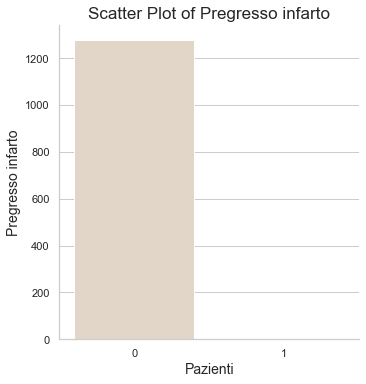

Descrizione Pregresso PTCA
count     1279
unique       1
top          0
freq      1279
Name: Pregresso PTCA, dtype: object

0% of missing Data



<Figure size 432x288 with 0 Axes>

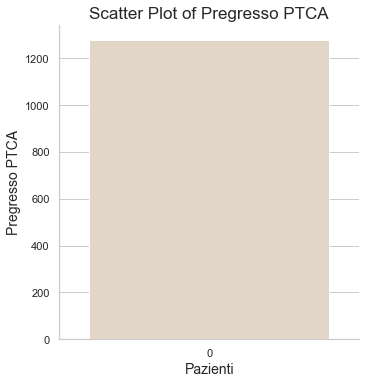

Descrizione Pregresso CABG
count     1279
unique       1
top          0
freq      1279
Name: Pregresso CABG, dtype: object

0% of missing Data



<Figure size 432x288 with 0 Axes>

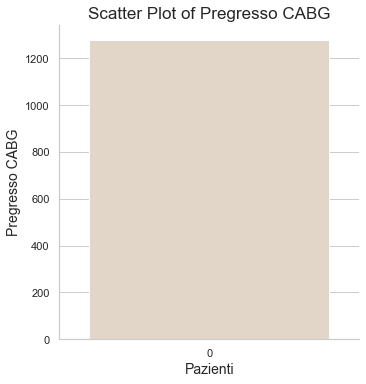

Descrizione Valutazione della funzione ventricolare sinistra
count     1282
unique       4
top          1
freq       890
Name: Valutazione della funzione ventricolare sinistra, dtype: object

0% of missing Data



<Figure size 432x288 with 0 Axes>

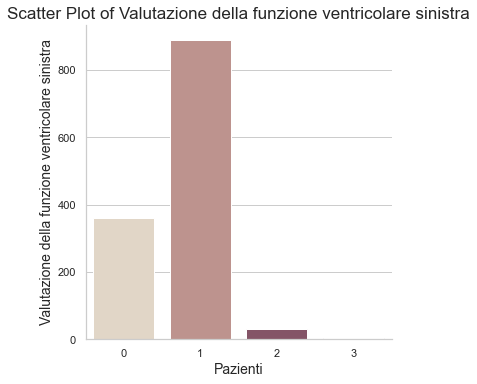

Descrizione ECG da sforzo
count     902
unique      4
top         1
freq      524
Name: ECG da sforzo, dtype: object

29% of missing Data



<Figure size 432x288 with 0 Axes>

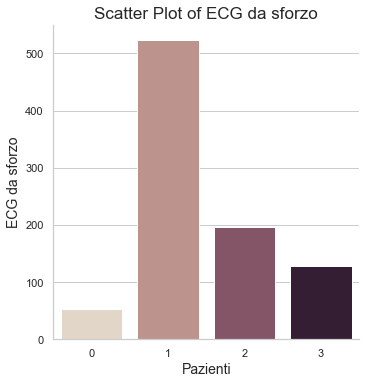

Descrizione Eco-stress
count     902
unique      4
top         0
freq      816
Name: Eco-stress, dtype: object

29% of missing Data



<Figure size 432x288 with 0 Axes>

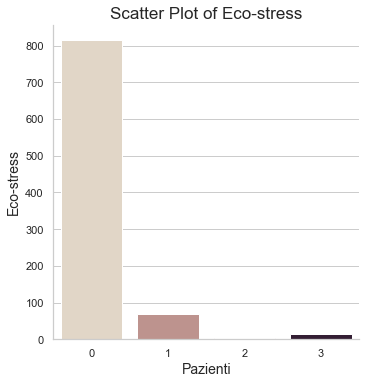

Descrizione Tomoscintigrafia da stress
count     902
unique      4
top         0
freq      835
Name: Tomoscintigrafia da stress, dtype: object

29% of missing Data



<Figure size 432x288 with 0 Axes>

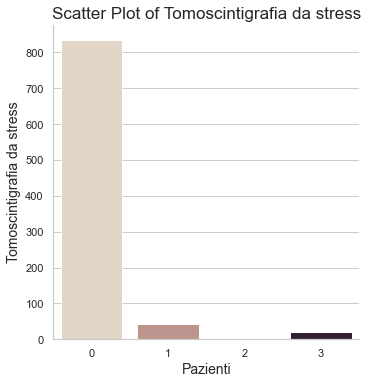

Descrizione RMN cardiaca da stress
count     902
unique      2
top         0
freq      883
Name: RMN cardiaca da stress, dtype: object

29% of missing Data



<Figure size 432x288 with 0 Axes>

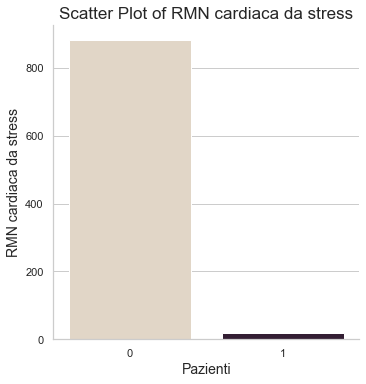

Descrizione FFR-CT
count     902
unique      3
top         0
freq      895
Name: FFR-CT, dtype: object

29% of missing Data



<Figure size 432x288 with 0 Axes>

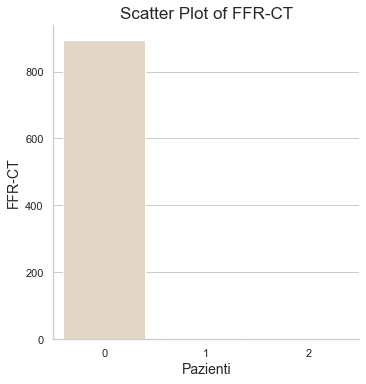

Descrizione CT-perfusion
count     901
unique      3
top         0
freq      893
Name: CT-perfusion, dtype: object

29% of missing Data



<Figure size 432x288 with 0 Axes>

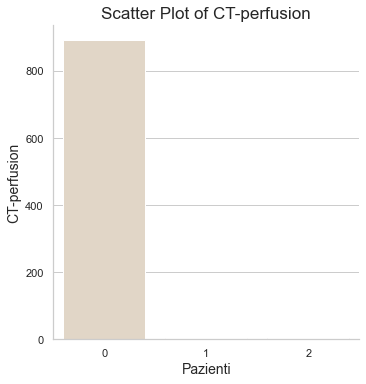

Descrizione Il paziente soffre o ha sofferto di patologie cliniche rilevanti diverse da malattie cardiache?
count     1284
unique       2
top          1
freq       677
Name: Il paziente soffre o ha sofferto di patologie cliniche rilevanti diverse da malattie cardiache?, dtype: object

0% of missing Data



<Figure size 432x288 with 0 Axes>

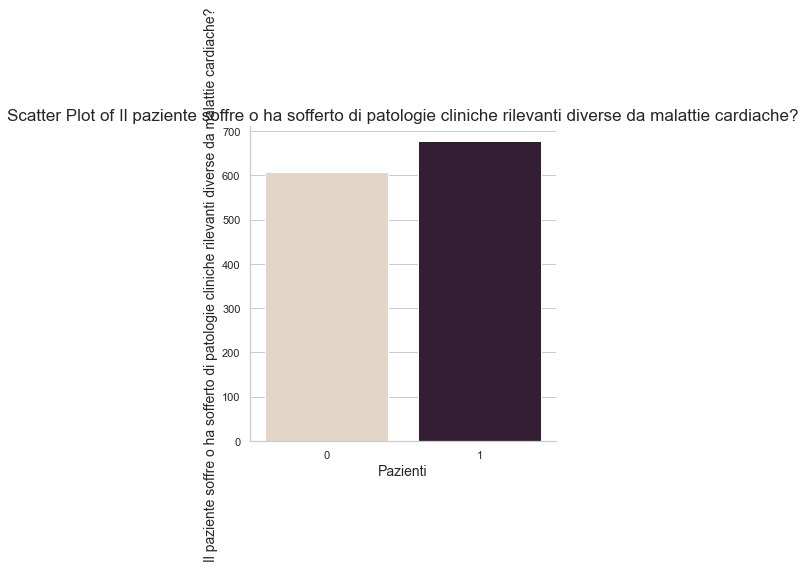

Descrizione E' in menopausa/andropausa ?
count     1279
unique       2
top          0
freq       840
Name: E' in menopausa/andropausa ?, dtype: object

0% of missing Data



<Figure size 432x288 with 0 Axes>

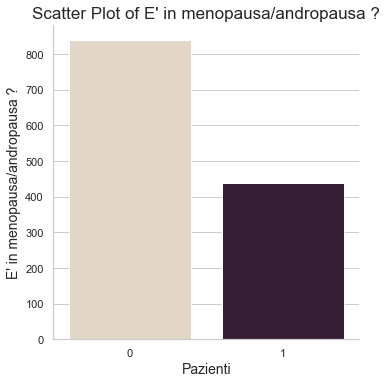

In [13]:
for i in cont_features:
    print('Descrizione ' + i)
    print(dataSet[i].describe(include = 'all'))
    print('')
    print(str(int((dataSet[i].isnull().sum()/len(dataSet[i]))*100)) + '% of missing Data')
    print('')
    plt.figure()
    sns.set_theme(style="whitegrid")
    sns.scatterplot(x=dataSet.index, y = dataSet[i])
    plt.title('Scatter Plot of ' + i, fontsize= 17)
    plt.xlabel('Pazienti', fontsize= 14)
    plt.ylabel(i, fontsize= 14)
    plt.show()

for i in cat_features:
    print('Descrizione ' + i)
    print(dataSet[i].describe(include = 'all'))
    print('')
    print(str(int((dataSet[i].isnull().sum()/len(dataSet[i]))*100)) + '% of missing Data')
    print('')
    plt.figure()
    sns.set_theme(style="whitegrid")
    sns.catplot(x=i, kind="count", palette="ch:.25", data=dataSet)
    plt.title('Scatter Plot of ' + i, fontsize= 17)
    plt.xlabel('Pazienti', fontsize= 14)
    plt.ylabel(i, fontsize= 14)
    plt.show()

In [14]:
dataSetCont = dataSet[cont_features]

#Creo un  sub-dataset con solo le variabili continue composto da sole le righe ha non hanno missing data
dfCont = dataSet[cont_features]
missingdata_df = dfCont.columns[dfCont.isnull().any()].tolist()


<AxesSubplot:>

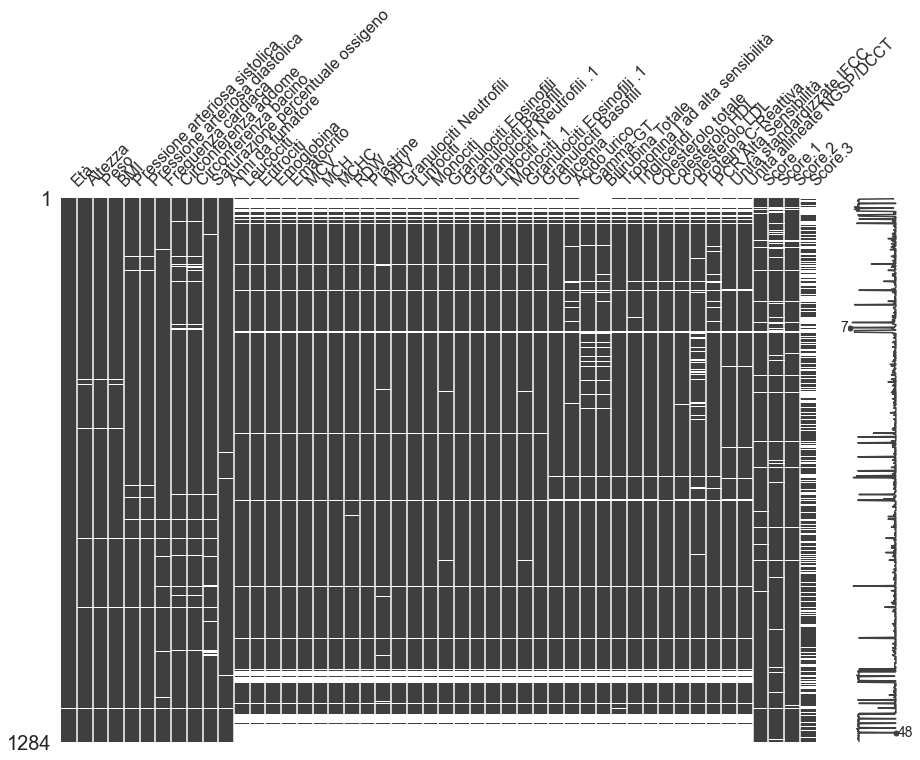

In [40]:
missingdata_df = dataSetCont.columns[dataSetCont.isnull().any()].tolist()
msno.matrix(dataSetCont[missingdata_df], figsize=(15,10)) # Nella parte destra del grafico notiviamo come ci sia una riga in cui mancano 138 elementi 
# e una in cui ne mancano 2

In [17]:
# IL dataset CONTIENE I DATI DELLA VISITA 1
#Prendo tutti i pazienti che hanno fatto la terza visita
dataSet_Visita3 = dataSet.loc[dataSet["Event Name"] == "Visita 3"]
dataSet_Visita1 = dataSet.loc[dataSet["Event Name"] == "Visita 1"]

In [18]:
features = ["ID PAZIENTE", "Data della visita", "Età", "Sesso", "Razza", "Altezza", "Peso ", "BMI",\
            "Pressione arteriosa sistolica ", "Pressione arteriosa diastolica", "Frequenza cardiaca",\
            "Circonferenza addome", "Circonferenza bacino", "Saturazione percentuale ossigeno",\
            "Il paziente è un fumatore?","Anni da fumatore",\
            "Il paziente ha familiari che hanno avuto uno o più eventi cerebrovascolari?",\
            "Il paziente ha familiari che hanno avuto uno o più eventi cardiovascolari?",\
            "Il paziente ha avuto una diagnosi di ipertensione?",\
            "Il paziente soffre di ipercolesterolemia?",
            "Il paziente soffre di arteriopatia periferica?", "Il paziente soffre di anemia?" ,\
            "Il paziente soffre di insufficienza renale cronica?","Il paziente soffre di sindrome trombofilica?",\
            "Leucociti ", "Eritrociti ", "Emoglobina ","Ematocrito ", "MCV ", "MCH", "MCHC", "RDW" , "Piastrine ",\
            "MPV ", "Granulociti Neutrofili ", "Linfociti ", "Monociti ", "Granulociti Eosinofili ",\
            "Granulociti Neutrofili .1", "Linfociti .1", "Monociti .1", "Granulociti Eosinofili .1", "Granulociti Basofili ",\
            "Glicemia ", "Acido urico ", "Gamma-GT ", "Bilirubina Totale ", "Troponina I ad alta sensibilità ", "Trigliceridi ",\
            "Colesterolo totale ", "Colesterolo HDL ", "Colesterolo LDL ", "Proteina C-Reattiva ", "PCR Alta Sensibilità ",\
            "Unità standardizzate IFCC ", "Classe NYHA"]
           
dataSet_Visita1 = dataSet_Visita1[features]

In [19]:
#Estraggo le variabili categoriche
dataSet_Visita1_cat = dataSet[cat_features]
#Estraggo le variabili continue
dataSet_Visita1_cont = dataSet[cont_features]

#A questo punto l'idea è quella di iniziare con un data completo ovvero senza missing data e poi andare a cancellare
# alcuni dati (il 5% per ogni colonna) in modo tale da poter valutare tramite RMSE l'algoritmo di imputing migliore
#Credo un dataset senza missing data
#del dataSet_Visita1_cont["Anni da fumatore"]
data1 = dataSet_Visita1_cont.dropna()
y_class = dataSet["Classe NYHA"]
#del data1["Classe NYHA"]

In [20]:
#Avendo sia il dataset originale che il dataset con i missing data vado a testare i tre diversi algoritmi per
#per l'imputing dei dati al fine di scegliere il migliore tramite la cifra di merito RMSE (il minore)



In [21]:
dataX =  data1.copy()

# E' necessario che i dati  siano normalizzati affinchè le varie tecniche possano funzionare
#Per prima cosa vado ad eseguire lo scaling del mio dataset
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(data1.values)
dataX = pd.DataFrame(X, columns = data1.columns)

X_miss, y_miss = add_missing_values(dataX, y_class) #è un dataframe (normalizzata) con i missing values

In [27]:
N_SPLITS = 5

x_labels = ['Zero imputation', 
            'Mean Imputation', 
            'KNN Imputation',  
            'Iterative Imputation Default',
            'Iterative Imputation Miss Forest',
            'Iterative Imputation DecisionTreesRegressor']


rmse_X = np.zeros(6)
algorithmZeroImp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
algorithmKNN = KNNImputer(missing_values=np.nan)
algorithmMean = SimpleImputer(missing_values=np.nan, strategy="mean")
algorithmII = IterativeImputer(missing_values=np.nan,random_state=0, n_nearest_features=5, sample_posterior=True)
algorithmEI = IterativeImputer(missing_values = np.nan,estimator = ExtraTreesRegressor(n_estimators=10, random_state=0))
algorithmDT = IterativeImputer(missing_values = np.nan, estimator = DecisionTreeRegressor(max_features='sqrt', random_state=0))


rmse_X[0] = get_impute_algorithm(X_miss, dataX, algorithmZeroImp) #RMSE ZERO-imputation
rmse_X[1] = get_impute_algorithm(X_miss, dataX, algorithmKNN) #RMSE KNN-imputation 
rmse_X[2] = get_impute_algorithm(X_miss, dataX, algorithmMean) #RMSE MEAN-imputation
rmse_X[3] = get_impute_algorithm(X_miss, dataX, algorithmII) #RMSE Iterative_Default-Imputation 
rmse_X[4] = get_impute_algorithm(X_miss, dataX, algorithmEI) #RMSE Iterative_ExtraTreeRegression-Imputation
rmse_X[5] = get_impute_algorithm(X_miss, dataX, algorithmDT) #RMSE Iterative_DecisionTreeRegression-Imputation

C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Antonio Montanaro\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


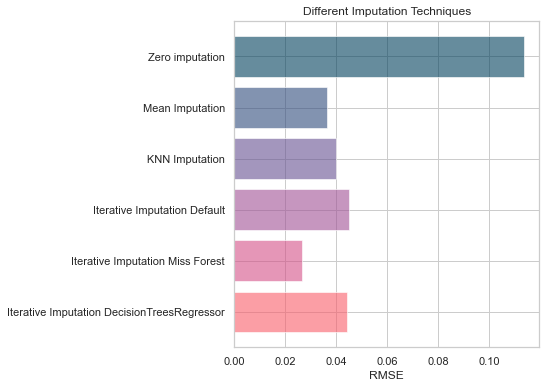

In [28]:
n_bars = len(rmse_X)
xval = np.arange(n_bars)

colors = ['#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600']

# plot risultati algoritmi tramite RMSE
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
for j in xval:
    ax1.barh(j, rmse_X[j],color=colors[j], alpha=0.6, align='center')

ax1.set_title('Different Imputation Techniques')
ax1.set_yticks(xval)
ax1.set_xlabel('RMSE')
ax1.invert_yaxis()
ax1.set_yticklabels(x_labels)

plt.show()